# ADs

In [ ]:

import pandas as pd
import numpy as np
from scipy import interp
from scipy.optimize import linprog # for convex hull test
import pickle # pickle.dump(obj, file, protocol=None)
from itertools import cycle
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import cm
#
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity, DistanceMetric
from sklearn.metrics.pairwise import pairwise_kernels
#
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, balanced_accuracy_score, precision_score, recall_score
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
# below are needed for AppDomainX
#
# formulae for estimating best bandwidth, note that we abondon the CV method for efficiency.
# though I personally consider the CV as the best, the CV may also not improve the result significantly
# we assume that the distribution has some Gaussian distribution characteristics
#
def getBandwidth(X):
    '''assume that the target distribution is normal.
    Silverman's rule for sinigle dimension
    the optimal bandwidth could be estimated reasonably by
    h = 1.06 * sigma * N**(-0.2)
    where sigma is the std. dev., N is the number of samples
    a better estimation could be:
    h = 1.06 * np.min([sigma,IQR/1.34]) * N**(-0.2),
    where
    IQR = upper_quartile - lower_quartile
    note IQR might be 0, in special cases
    '''
    # calculate the lower and upper quartiles of the training samples
    q25, q75 = np.quantile(X, [0.25, 0.75])
    IQR = q75-q25 # inter-quantile range as a more robust measure of the distribution
    sigma = X.std() # standard deviation as the alternative 'standard' solution
    N = X.shape[0] # number of the samples
    if IQR > 0: # the better way to estimate bandwidth, replace the standard deviation with robust estimation of the range of distribution
        return 1.06 * np.min([sigma,IQR/1.34]) * N**(-0.2) # silverman rule-of-thumbs bandwidth - robust version (consider outliers)
    elif sigma > 0:
        return 1.06 * sigma * N**(-0.2) # silverman rule of thumb
    else:
        raise ValueError('This is a constant feature!')
#
#
class SrKDE:
    '''a custom KDE for a SINGLE feature vector
    during initialization, 'best' bandwidth is estimated
    a sklearn.neighbors.KernelDensity instance will be made, the kernel is 'gaussian' by default
    the log_e Probability densities will be calculated as self.log_dens_train
    # how to use SrKDE?
    # initializing
    sKde = SrKDE(df_c2['BCUTd-1l'])
    # plot with outlier criteria
    sKde.plotDistribution(outlierPerc=0.1)
    # get outlier threshold
    sKde.getOutlierThres(outlierPerc=0)
    # plot segments with different colors
    sKde.plotInsiderOutlierSegments()'''
    def __init__(self, sr, kernelType='gaussian'):
        self.sr = sr # Could this consume some memory? Tests needed
        self.X = sr.values[:,np.newaxis]
        self.kernelType = kernelType
        self.descNym = sr.name
        self.h = getBandwidth(self.X)
        self.kde = KernelDensity(kernel=kernelType, bandwidth=self.h).fit(self.X)
        self.log_dens_train = self.kde.score_samples(self.X)
    def getOutlierThres(self, outlierPerc=0):
        '''(0): use this percentile as the threshold for counting outliers
        which is equivalent to using minimum estimated probability density as the outliers
        when the outlierPerc increase (until 100), the applicability domain will shrink, and thus be stricter.
        '''
        # based on which, check the training set log_dens
        return np.quantile(self.log_dens_train,outlierPerc)
    def plotDistribution(self, patchRatio=0.1, denseFold=3, jitterPosYRatio=0.1, alpha=0.05, plotOutlierThresLine=True, outlierPerc=0):
        '''plot the estimated distribution of the training samples.
        Here most parameters are used for better visualization.
        patchRatio(=0.1): lower and upper limit of x axis will be extended by patchRatio * difference_of_extrema (of training samples)
        denseFold(=3): number of x points used for plot will be at least 3 times of the samples; or 1000 if denseFold * N_plot < 1000
        jitterPosYRatio(=0.1): this will be used to plot the randomized intensity of data points
        alpha(=0.05): transparency used to plot each data point in the jitter region. Use lesser values to avoid thick plot.
        plotOutlierThresLine(=True): by default, the threshold line will be added in the plot
        outlierPerc(=0): if the threshold line is added, this will be used to specify the height of the line.
        '''
        # preparing parameters for best visualization
        X = self.X
        dExtremeRange = patchRatio*(X.max() - X.min())
        xLeft = X.min() - dExtremeRange
        xRight = X.max() + dExtremeRange
        # using five-fold denser data points than the training data set
        N_plot = X.shape[0]*denseFold
        if N_plot < 1000: N_plot = 1000
        X_plot = np.linspace(xLeft, xRight, N_plot)[:, np.newaxis]
        log_dens = self.kde.score_samples(X_plot)
        prob_dens = np.exp(log_dens)
        yMax = prob_dens.max()
        # plot
        fig, ax = plt.subplots()
        ax.plot(X_plot[:, 0], np.exp(log_dens), 'b-', linewidth=0.75, label="kernel = '{0}'".format(self.kernelType))
        ax.plot(X[:, 0], - jitterPosYRatio * yMax * np.random.random(X.shape[0]), '+k', alpha=alpha)
        if plotOutlierThresLine:
            ax.hlines(np.exp(self.getOutlierThres(outlierPerc)),xLeft,xRight,linestyle='solid',linewidth=1.25,color='red')
        ax.legend(loc='best') # 'upper right'
        ax.set_xlabel("distribution of '{}'".format(self.descNym))
    def plotInsiderOutlierSegments(self, patchRatio=0.1, denseFold=5, jitterPosYRatio=0.1, alpha=0.05, outlierPerc=0):
        '''I know someone pursue better visualization of the distribution with threshold
        Well this is my trying, just for fun
        details of the tuning parameters: see SrKDE.plotDistribution()
        '''
        # special import
        from matplotlib.collections import LineCollection
        from matplotlib.colors import ListedColormap, BoundaryNorm
        # preparing parameters for best visualization
        X = self.X
        dExtremeRange = patchRatio*(X.max() - X.min())
        xLeft = X.min() - dExtremeRange
        xRight = X.max() + dExtremeRange
        # using five-fold denser data points than the training data set
        N_plot = X.shape[0]*denseFold
        if N_plot < 10000: N_plot = 10000
        X_plot = np.linspace(xLeft, xRight, N_plot)[:, np.newaxis]
        log_dens = self.kde.score_samples(X_plot)
        y = np.exp(log_dens)
        yMax = y.max()
        x = X_plot[:,0]
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        #
        fig, ax = plt.subplots()
        cmap = ListedColormap(['red','blue'])
        norm = BoundaryNorm([-np.inf,self.getOutlierThres(outlierPerc),np.inf], cmap.N)
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        lc.set_array(log_dens)
        lc.set_linewidth(1.5)
        #lc.set_label("kernel = '{0}'".format(self.kernelType))
        line = ax.add_collection(lc)
        #fig.colorbar(line, ax=ax)
        ax.plot(X[:, 0], - jitterPosYRatio* yMax * np.random.random(X.shape[0]), '+k', alpha=alpha)
        #ax.legend(loc='best') # 'upper right'
        ax.set_xlabel("{} KDE distribution of '{}'".format(self.kernelType,self.descNym))
    def filterXeno(self, srXeno, outlierPerc=0):
        '''based on the precalculated log_dens_xeno, the index of compounds
        whose probability is not less than the outlier threshold will be given.
        i.e., indices the compounds within applicability domain will be returned
        '''
        return srXeno.index[self.log_dens_xeno >= self.getOutlierThres(outlierPerc)]
    def checkXeno(self, srXeno):
        '''checkXeno(srXeno) will calculate the log_e probability density of a given pandas.Series
        the results will be stored as self.log_dens_xeno, which will be refered to rapidly during a perc shifting study
        '''
        self.log_dens_xeno = self.kde.score_samples(srXeno.values[:,np.newaxis])
#
#
scalerTypeDict = {
'min-max':preprocessing.MinMaxScaler,
'standard':preprocessing.StandardScaler}
#
class HullShade:
    '''Hull shade is not a real convex hull, but is a fast, but not exactly equivalent strategy
    (due to the tolerance of linear programming solver)
    to test whether a point is inside the convex hull, which is desired for AD filtering
    the strategy is to transform the problem of obtaining a convex hull into a linear programming problem.
    Warning! HullShade will not exactly obtain the same results from genuine convex hull methods!
    Especially in high-dimensional space, the HullShade will have errors dependent on the tolerance assigned.
    '''
    def __init__(self, points):
        '''points.shape = (n_points, n_dim)'''
        self.points = points
        n_points, n_dim = points.shape
        self.c = np.zeros(n_points)
        self.A = np.r_[points.T, np.ones((1,n_points))]
    def p_in_hull(self, x):
        b = np.r_[x, np.ones(1)]
        lp = linprog(self.c, A_eq=self.A, b_eq=b)
        return lp.success
    def ps_in_hull(self, xs):
        return np.array([self.p_in_hull(x) for x in xs])
#

class AppDomainX:
    '''Applicability domain based on specific training set X data & preset options
    #
    Supported A.D. are *(_analyze, _xenoCheck, _xenoFilter):
    KDE:        kernel density estimation based non-parameter distribution (strict and slightly slow)
    hatValue:   leverages inspired by Williams plot
    LUP:        lower and upper percentile hyper-dimensional box
    convexHull: convex hull hyper-dimensional wrapping surface (could be very slow and strict)
    distance:   based on various type of distance calculated from input features
    [there are 2 strategies for distance metrics: pairwise or centroid]
    #
    for multi-variate linear regression, KDE, hatValue, convexHull are recommended ADs
    for classification, KDE, distance are recommended ADs.
    the LUP is a very fast but coarse AD, it is not recommended for serious cases.
    '''
    def __init__(self,dfTrain,XLabels):
        '''to initialize an AppDomain, a df with proper data is needed
        also needed are yCol and XCols that indicate y and X values'''
        self.dfX = dfTrain[XLabels]
        # these labels are kept for extracting external data set columns!
        self.XLabels = XLabels
    def KDE_analyze(self, kernelType='gaussian', fLoose=1):
        '''outlierPerc(0): use this percentile as the threshold for counting outliers
        which is equivalent to using minimum estimated probability density as the outliers
        when the outlierPerc increase (until 100), the applicability domain will shrink, and thus be stricter.
        KDE means that a kernel density estimation will be applied
        the bandwidth of gKernels will be estimated from each feature vectors, respectively.
        '''
        X00 = self.dfX.values
        self.bw = np.array([getBandwidth(v) for v in X00.T])*fLoose
        X0 = np.array([v/h for v,h in zip(X00.T, self.bw)]).T
        self.kde = KernelDensity(kernel=kernelType, bandwidth=1.0).fit(X0)
        self.KDE_genRandomSamples()
    def KDE_genRandomSamples(self, n_samples=10000, random_state=0):
        '''generate random samples according to the established KDE'''
        self.prob_ln_dens = self.kde.score_samples(self.kde.sample(n_samples=n_samples, random_state=random_state))
    def KDE_xenoCheck(self, dfXeno):
        '''calculate and return the ln density of external samples
        the returned density is a Pandas Series object, with index as their names'''
        Xe0 = dfXeno[self.XLabels].values
        Xe = np.array([v/h for v,h in zip(Xe0.T, self.bw)]).T
        return pd.Series(self.kde.score_samples(Xe), index=dfXeno.index)
    def KDE_xenoFilter(self, srXeno_ln_dens, outlierPerc=5):
        '''based on the input ln density of the query samples,
        returns the list of compounds that fall inside the KDE AD defined by given outlier percentile'''
        densThres = np.percentile(self.prob_ln_dens, outlierPerc)
        return srXeno_ln_dens[srXeno_ln_dens >= densThres].index
        #
    def hatValue_analyze(self, useXPlus=True):
        '''hat matrix and hat values could be calculated as app domain from X
        Warning: if highly inter-relevant features exist in X, the result will be abnormally wrong!
        '''
        self.useXPlus = useXPlus
        if useXPlus:
            X = np.matrix(np.column_stack([np.ones(self.dfX.shape[0]),self.dfX.values.astype(float)]))
        else:
            X = self.dfX.values.astype(float)
        # hat matrix 
        self.hatCoreMatrix = (X.T * X).I
        hatMatrix = X * self.hatCoreMatrix * X.T
        # its diagonal elements are hat values
        self.sr_hatVals = pd.Series(np.diagonal(hatMatrix), index=self.dfX.index)
        # criterion for judging outliers
        self.hatValCriteria = 3*(self.dfX.shape[1])/self.dfX.shape[0]
    def hatValue_xenoCheck(self, dfXeno):
        if self.useXPlus:
            X = np.matrix(np.column_stack([np.ones(dfXeno[self.XLabels].shape[0]),dfXeno[self.XLabels].values.astype(float)]))
        else:
            X = dfXeno[self.XLabels].values.astype(float)
        hatMatrix = X * self.hatCoreMatrix * X.T
        # its diagonal elements are hat values
        return pd.Series(np.diagonal(hatMatrix), index=dfXeno.index)
    def hatValue_xenoFilter(self, sr_hatValsXeno):
        #sr_hatValsXeno = self.hatValueXenoCheck(dfXeno)
        return sr_hatValsXeno[sr_hatValsXeno < self.hatValCriteria].index
    def genX_PC(self, n_components=None):
        '''generate principal components for the original descriptors
        the results will be saved as self.PCNyms and self.dfX_PC
        if n_components is None, number of the generated PCs will be equal to that of the original descriptors'''
        X0 = self.dfX.values.astype(float)
        self.pcaFull = PCA(n_components=n_components)
        self.pcaFull.fit(X0)
        Xpc = self.pcaFull.transform(X0)
        self.PCNyms = ['PC'+str(i) for i in range(1,Xpc.shape[1]+1)]
        self.dfX_PC = pd.DataFrame(Xpc, index=self.dfX.index, columns=self.PCNyms)
        #
    def map_dfXeno2PC(self, dfXeno):
        Xe0 = dfXeno[self.XLabels].values.astype(float)
        return pd.DataFrame(self.pcaFull.transform(Xe0), index=dfXeno.index, columns=self.PCNyms)
    def LUP_analyze(self,lowerPerc=0, upperPerc=100, PC_Space=False):
        '''A coarse yet universal "multi-dimensional hyperbox" applicability domain (no matter effective or not)
        Lower and upper percentile limits (default lowerPerc=0, upperPerc=100, corresponding to min, max)
        # eval the LUP on actual training set (excluding compounnds from df_preserved)
        # based on truly used features, calculate their LUP'''
        self.PC_space = PC_space
        if PC_Space:
            dfX = self.dfX_PC
        else:
            dfX = self.dfX
        self.sr_lowerPercentile = pd.Series(np.percentile(dfX,lowerPerc,axis=0),dfX.columns)
        self.sr_upperPercentile = pd.Series(np.percentile(dfX,upperPerc,axis=0),dfX.columns)
    def LUP_xenoCheck(self,df_xeno):
        '''df_xeno: dataframe that share the 'featuresChosen' with training set
        cutoffSize=0: allowed number of descriptors that exceed the min-max domain of training set
                      filter compounds whose 'count of min-max break' <= cutoffSize;
                      when the cutoffSize gets larger, the AD will be less strict'''
        if self.PC_Space:
            XLabels = self.PCNyms
        else:
            XLabels = self.XLabels
        sr_lower_break_count = (df_xeno[XLabels] < self.sr_lowerPercentile).sum(axis=1)
        sr_upper_break_count = (df_xeno[XLabels] > self.sr_upperPercentile).sum(axis=1)
        sr_break_count = sr_lower_break_count + sr_upper_break_count
        sr_break_count.name = 'count_outside_lowerUpperPercentiles'
        return sr_break_count
    def LUP_xenoFilter(self, sr_break_count, cutoffSize=0):
        '''sr_break_count: returned pd.Series by breakCountLUP()
        cutoffSize(=0): count of breaks allowed as points within AD'''
        return sr_break_count[sr_break_count <= cutoffSize].index
    #
    def convexHull_analyze(self):
        self.hullTr = ConvexHull(self.dfX.values)
    #
    def convexHull_xenoFilter(self,df_xeno):
        '''Even though identification of tested point(s) within convex hull
        has been greatly accelerated with the HullShade.p_in_hull() method.
        for hyper-dimensional descriptor space (e.g. 1000 descriptors) 
        and large number of training sets the calculation will be extremely slow
        Besides, the hyper-dimensional convex hull could be extremely small that basically not useful.
        '''
        if self.XLabels.shape[0] > 6:
            print('High dimension convex hull could be overly narrorw and error-prone!')
        mask = []
        for cmpd in df_xeno.index:
            new_points = np.append(self.dfX.values, [df_xeno.loc[cmpd, self.XLabels].values], axis=0)
            new_hull = ConvexHull(new_points)
            if list(self.hullTr.vertices) == list(new_hull.vertices):
                mask.append(True)
            else:
                mask.append(False)
        return df_xeno.index[mask]
    #
    def distance_analyze(self,distanceType='euclidean',scalerType='standard',centroidType='mean',V=None):
        '''distanceType:
            1. "euclidean" (default)
            2. "seuclidean" (weighted V needed)
            3. "mahalanobis"
            4. "manhattan" (aka city-block; slowest, and similar to Euclidean),
            5. "cosine" (distinct from the previous)
        scalerType:
            1. "min-max" scaler: scale range into [0,1]
            2. "standard" scaler: scaled distribution has mean = 0, and sd = 1 (default)
        centroidType:
            1. "mean" (default)
            2. "median"
        '''
        X0 = self.dfX.values.astype(float)
        self.scalerType = scalerType
        self.scalerAD = scalerTypeDict[scalerType]()
        self.scalerAD.fit(X0)
        self.X = self.scalerAD.transform(X0)
        # strategy I
        self.distanceType = distanceType
        if distanceType == 'mahalanobis':
            V = np.cov(self.X, rowvar=False)
            self.used_distances = DistanceMetric.get_metric(distanceType,V=V)
        elif distanceType == 'seuclidean':
            # weighted in a dividing manner
            self.used_distances = DistanceMetric.get_metric(distanceType,V=1/V)
        elif distanceType in ['euclidean','manhattan','cosine']:
            self.used_distances = DistanceMetric.get_metric(distanceType)
        else:
            raise ValueError('Unknown distance type')
        self.DM_trained = self.used_distances.pairwise(self.X)
        # strategy II
        self.descriptorSpaceCentroidType = centroidType
        if centroidType == 'mean':
            self.centroid_trained = self.X.mean(axis=0) # one might also wanna use self.X.median(axis=0)
        elif centroidType == 'median':
            self.centroid_trained = np.median(self.X, axis=0)
        else:
            raise TypeError('Not supported centroidType: '+centroidType)
        self.radiusVec = self.used_distances.pairwise([self.centroid_trained], self.X)[0,:]
    def distancePairwise_xenoCheck(self, df_xeno):
        '''df_xeno: dataframe that share the 'featuresChosen' with training set
        the valid descriptor X will be extracted from df_xeno, and be transformed into
        the scaled version by the registered self.scalerAD
        return:
            the pairwise distance matrix between the (scaled) training set and the external set'''
        Xext = self.scalerAD.transform(df_xeno[self.XLabels].values.astype(float))
        return self.used_distances.pairwise(self.X, Xext)
    def distancePairwise_xenoFilter(self, df_xeno, distExt, dCutoff, nNear=1):
        '''dCutoff: a cutoff distance to define a sphere within which the compounds are categorized as 'near' the training point(s)
        Note: when dCutoff is larger, the AD will be less strict.
              the dCutoff will be strongly dependent on the 'scalerType'.
              Distribution of distance matrix is recommended to be checked beforehand, to determine proper dCutoff(s)
        nNear=1: count of 'near' compounds that meet the 'dCutoff' standard;
        Note: when nNear is larger, the AD will be stricter.'''
        mask = (distExt <= dCutoff).sum(axis=0) >= nNear
        # return the index that meet the mask condition
        return df_xeno.index[mask]
        #
    def distancePairwise_hist(self, num_bins=50):
        '''plot the pairwise distances of training set points
        [redundant pairs are excluded by np.triu_indices()]
        variables:
            num_bins (50): for drawing the histogram
        return:
            dData: is the pairwise distances (flattened in 1d)
            (mu, sigma): a tuple contains the mean and standard deviation of the dData
        '''
        dData = self.DM_trained[np.triu_indices(self.DM_trained.shape[0],1)]
        fig, ax = plt.subplots()
        n, bins, patches = ax.hist(dData, bins=num_bins, density=1)
        mu = dData.mean()
        sigma = dData.std()
        # add a 'best fit' line
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        ax.plot(bins, y, '--')
        ax.set_xlabel('distance ({:})'.format(self.distanceType))
        ax.set_ylabel('probability density')
        ax.set_title(r'$\mu={:.3f}$, $\sigma={:.3f}$'.format(mu,sigma))
        fig.tight_layout()
        return dData, (mu, sigma)
        #
    def distancePairwise_xenoHist(self, DM_ext, dCutoff=None, num_bins=50):
        '''DM_ext: external/xeno distance matrix
        dCutoff: 
        '''
        if dCutoff is None:
            dData = DM_ext.reshape(DM_ext.shape[0]*DM_ext.shape[1])
        else:
            dData = DM_ext[DM_ext <= dCutoff]
        fig, ax = plt.subplots()
        n, bins, patches = ax.hist(dData, bins=num_bins, density=1)
        mu = dData.mean()
        sigma = dData.std()
        # add a 'best fit' line
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        ax.plot(bins, y, '--')
        ax.set_xlabel('distance ({:})'.format(self.distanceType))
        ax.set_ylabel('probability density')
        ax.set_title(r'$\mu={:.3f}$, $\sigma={:.3f}$'.format(mu,sigma))
        fig.tight_layout()
        return dData, (mu, sigma)
        #
    def distanceP2PsStatCheck(self, DM_ext, stat='mean'):
        '''DM_ext: distance matrix of the external set
        stat('mean', 'max', 'median', percentiles[0,100]): statistics of distances between the query point and
        all training-set points, as final distance
        return:
        tuple of the specified statistics of the external and training set points
        xenoRadiusVec, trainRadiusVex
        '''
        self.dP2PsStatistics = stat
        if stat == 'mean':
            self.distVec = self.DM_trained.mean(axis=0)
            return DM_ext.mean(axis=0)
        elif stat == 'max':
            self.distVec = self.DM_trained.max(axis=0)
            #self.naiveRef = np.argmax(self.DM_trained,axis=0)
            #self.maxStatRefCmpds = self.
            return DM_ext.max(axis=0)
        elif stat == 'median':
            self.distVec = np.median(self.DM_trained, axis=0)
            return np.median(DM_ext, axis=0)
        elif ((stat <= 100) & (stat >= 0)):
            self.distVec = np.percentile(self.DM_trained, stat, axis=0)
            return np.percentile(DM_ext, stat, axis=0)
        else:
            raise ValueError('Not supported statistics!')
    def distanceP2PsStatFilter(self, df_xeno, xenoDistVec, distPerc=100, distThres=None):
        '''DM_ext: distance matrix of the external set'''
        if distThres is None:
            mask = xenoDistVec <= np.percentile(self.distVec, distPerc)
        else:
            mask = xenoDistVec <= distThres
        return df_xeno.index[mask]
        #
    def distanceCentroid_xenoCheck(self, df_xeno):
        '''centroid away distance'''
        Xext = self.scalerAD.transform(df_xeno[self.XLabels].values.astype(float))
        return self.used_distances.pairwise([self.centroid_trained], Xext)[0,:]
    def distanceCentroid_xenoFilter(self, df_xeno, xenoRadiusVec, radiusPerc=100, radiusThres=None):
        '''default radiusPerc=100, equivalent to maximum radius'''
        if radiusThres is None:
            mask = xenoRadiusVec <= np.percentile(self.radiusVec, radiusPerc) # at least one that is not outside the max
        else:
            mask = xenoRadiusVec <= radiusThres
        # return the index that meet the mask condition
        return df_xeno.index[mask]
    def distanceCentroid_PC2(self, df_xeno):
        '''return top 2 principal components of training set and xeno set as [n compounds,2] matrix'''
        self.pca = PCA(n_components=2)
        self.pca.fit(self.X)
        Xext = self.scalerAD.transform(df_xeno[self.XLabels].values.astype(float))
        return self.pca.transform(self.X), self.pca.transform(Xext)
    def PC2_distanceCentroid_landscape(self, df_xeno, radiusPerc=100, radiusThres=None):
        '''plot a landscape based on top 2 principal components and the Euclidean distance from the centroid compound
        '''
        xenoRadiusVec = self.distanceCentroid_xenoCheck(df_xeno)
        adi = self.distanceCentroid_xenoFilter(df_xeno, xenoRadiusVec, radiusPerc, radiusThres) # 100: use max radius
        #
        Tr, Te = self.distanceCentroid_PC2(df_xeno.loc[adi])
        # training set
        x = Tr[:,0]
        y = Tr[:,1]
        z = self.radiusVec
        # external set
        xe = Te[:,0]
        ye = Te[:,1]
        ze = self.distanceCentroid_xenoCheck(df_xeno.loc[adi])
        # concatenated x, y, z (uniform landscape)
        xa = np.concatenate([x,xe])
        ya = np.concatenate([y,ye])
        za = np.concatenate([z,ze])
        # plot
        fig, ax2 = plt.subplots()
        ax2.plot(x,y,'ko',alpha=1,markersize=3,markerfacecolor='white',markeredgewidth=0.5) # markeredgewidth=1
        ax2.plot(xe,ye,c='lime',marker='v',linestyle='',alpha=0.3,markersize=3)
        ax2.tricontour(xa,ya,za,levels=20,linewidths=0.0,colors='gray')
        cntr2 = ax2.tricontourf(xa,ya,za, levels=20, cmap="RdBu_r")
        fig.colorbar(cntr2, ax=ax2)
        ax2.axis((xa.min(), xa.max(), ya.min(), ya.max()))
        ax2.set_title('PCA distance Centroid landscape')
        return adi
#
# fingerprints modules implemented in RDKit
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem.AtomPairs import Torsions
#
simiMetricDict = {
'Tanimoto':DataStructs.BulkTanimotoSimilarity,
'Dice':DataStructs.BulkDiceSimilarity,
'cosine':DataStructs.BulkCosineSimilarity}
#
fpTypeDict = {
'topology':FingerprintMols.FingerprintMol,
'Morgan(bit)':AllChem.GetMorganFingerprintAsBitVect,
'Morgan(count)':AllChem.GetMorganFingerprint,
'atom_pair(bit)':Pairs.GetAtomPairFingerprintAsBitVect,
'atom_pair(count)':Pairs.GetAtomPairFingerprint,
'top_torsion':Torsions.GetTopologicalTorsionFingerprintAsIntVect,
'MACCS_keys':MACCSkeys.GenMACCSKeys}
#
class AppDomainFpSimilarity:
    '''Molecular fingerprint similarity-based applicability domain manager.
    Notice that fingerprint similarity is intrinsically in a pairwise manner.
    That is, NO average/centroid/reference fingerprint/data_point could be created (meaningful).
    For pairwise applicability domain, there are 2 parameters to tune: a threshold of the metric, and a count of members that meet that threshold.
    I personally recommend the Morgan radius 2 (i.e. ECFP4) with fixed bits (no more than 1024 bits)
    '''
    def __init__(self, dfTrain, smiCol):
        '''a pd.Series of SMILES code will be stored
        # illegal SMILES will raise error'''
        self.sr_smi = dfTrain[smiCol]
        self.ms = [Chem.MolFromSmiles(smi) for smi in self.sr_smi]
    def fpSimilarity_analyze(self, fpType, simiMetric='Tanimoto', **fpOpt): # radius=2, nBits=1024
        '''fpType: fingerprint to be used
        simiMetric: similarity metric to be used
        fpOpt: key words that used along with fpType
        supported fpType:
            'topology': (basic) Daylight-like fingerprint (ExplicitBitVect, 2048 bits)
            'Morgan(bit)': circular/ECFP-like fingerprint, folded into fixed length, radius and nBits are needed (ExplicitBitVect, specified nBits)
            'Morgan(count)': circular/ECFP-like fingerprint, not folded (UIntSparseIntVect, 4294967295 bits)
            'atom_pair(bit)': atom pair fingerprint (SparseBitVect, 8388608 bits)
            'atom_pair(count)': atom pair fingerprint (IntSparseIntVect, 8388608 bits)
            'top_torsion': topological torsion fingerprint (LongSparseIntVect, 68719476735 bits)
            'MACCS_keys': MACCS keys (ExplicitBitVect, 167 bits)
        * According to personal tests, Morgan fingerprints ((radius 2, 1024/less bit) is reasonable both in chemistry intuition and time cost.
        supported simiMetric:
            'Tanimoto' (mostly used, default)
            'Dice' (more suitable for atom pair & topological torsion fingerprints)
            'cosine'
        '''
        self.fpType = fpType
        self.simiMetric=simiMetric
        self.fps_trained = [fpTypeDict[fpType](m,**fpOpt) for m in self.ms]
        # calculated similarityMatrix (SM) might be useful for other use
        self.SM_trained = np.array([simiMetricDict[simiMetric](self.fps_trained[i],self.fps_trained) for i in range(len(self.fps_trained))])
        self.fpOpt = fpOpt
        #
    def fpSimilarity_hist(self, num_bins=50):
        sData = self.SM_trained[np.triu_indices(self.SM_trained.shape[0],1)]
        fig, ax = plt.subplots()
        n, bins, patches = ax.hist(sData, bins=num_bins, density=1)
        mu = sData.mean()
        sigma = sData.std()
        # add a 'best fit' line
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        ax.plot(bins, y, '--')
        ax.set_xlabel('similarity ({:})'.format(self.simiMetric))
        ax.set_ylabel('probability density')
        ax.set_title(r'$\mu={:.3f}$, $\sigma={:.3f}$'.format(mu,sigma))
        fig.tight_layout()
        return sData, (mu, sigma)
    


        #
    def fpSimilarity_xenoHist(self, SM_ext, num_bins=50):
        sData = SM_ext.reshape(SM_ext.shape[0]*SM_ext.shape[1])
        fig, ax = plt.subplots()
        n, bins, patches = ax.hist(sData, bins=num_bins, density=1)
        mu = sData.mean()
        sigma = sData.std()
        # add a 'best fit' line
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        ax.plot(bins, y, '--')
        ax.set_xlabel('similarity ({:})'.format(self.simiMetric))
        ax.set_ylabel('probability density')
        ax.set_title(r'$\mu={:.3f}$, $\sigma={:.3f}$'.format(mu,sigma))
        fig.tight_layout()
        return sData, (mu, sigma)
        #
    def fpSimilarity_xenoCheck(self, df_xeno, smiCol):
        '''df_xeno: dataframe that share the 'featuresChosen' with training set
        smiCol: column corresponding to SMILES code (illegal SMILES will raise error)'''
        ms = [Chem.MolFromSmiles(smi) for smi in df_xeno[smiCol]]
        fps = [fpTypeDict[self.fpType](m,**self.fpOpt) for m in ms]
        return np.array([simiMetricDict[self.simiMetric](fp,self.fps_trained) for fp in fps])
    def fpSimilarity_xenoFilter(self, df_xeno, similarityMatrix, thresSimilar=0.25, nSimilar=1):
        '''all fingerprint type compatible xenoFilter
        df_xeno: dataframe that share the 'featuresChosen' with training set
        similarityMatrix: the Tanimoto similarity matrix returned by AppDomainFpSimilarity.fpMorganTc_xenoCheck()
        thresSimilar(default=0.25): by (>=) which structures 'similar' to training set are identified;
                                    when the similarity is larger, the AD will be stricter.
        nSimilar(default=1): number of compounds that meet the thresSimilar standard;
                             when the number is larger, the AD will be stricter.
        '''
        TanimotoExtBool = similarityMatrix >= thresSimilar
        mask = TanimotoExtBool.sum(axis=1) >= nSimilar
        return df_xeno.index[mask]
    def similarityP2PsStatCheck(self, SM_ext, stat='mean'):
        '''SM_ext: similarity matrix of the external set
        stat('mean', 'max', 'median', percentiles[0,100]): statistics of similarities between the queried compound and
        all training-set compounds, as final similarity
        return:
        xenoRadiusVec
        '''
        self.dP2PsStatistics = stat
        if stat == 'mean':
            self.simiVec = self.SM_trained.mean(axis=1)
            return SM_ext.mean(axis=1)
        elif stat == 'median':
            self.simiVec = np.median(self.SM_trained, axis=1)
            return np.median(SM_ext, axis=1)
        elif ((stat <= 100) & (stat >= 0)):
            self.simiVec = np.percentile(self.SM_trained, stat, axis=1)
            return np.percentile(SM_ext, stat, axis=1)
        else:
            raise ValueError('Not supported statistics!')
    def similarityP2PsStatFilter(self, df_xeno, xenoSimiVec, simiPerc=100, simiThres=None):
        '''SM_ext: distance matrix of the external set'''
        if simiThres is None:
            mask = xenoSimiVec >= np.percentile(self.simiVec, simiPerc)
        else:
            mask = xenoSimiVec >= simiThres
        return df_xeno.index[mask]
        #
#

# -------------------------------------
# --- Tools Section (visualization) ---
# -------------------------------------
def fluctualROCs(yValsList, fignym='mROCs.png'):
    '''plot a set of ROCs according to a given yValsList
    elements in yValsList are list or tuple like [yp, prob_yp, yt]
    where yp is not actually needed for ROC (but will be used for accuracy_score), thus just a placeholder
    the order of yVals are consistent with the VoterII and UnitModel predict output.
    '''
    AUCList = []
    accuracyList = []
    #
    tprs = []
    mean_fpr = np.linspace(0,1,101)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    #
    for i, yVals in enumerate(yValsList):
        # train a voter with fold.pool!
        yp, prob_yp, yt = yVals
        fpr, tpr, thresholds = roc_curve(yt, prob_yp)
        roc_auc = auc(fpr, tpr)
        AUCList.append(roc_auc)
        #
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 #?
        ax.plot(fpr,tpr,lw=1,alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
        accuracyList.append(accuracy_score(yt, yp))
    # final ornaments
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
    label='Chance', alpha=.8)
    #
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0 #?
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(AUCList)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower left", bbox_to_anchor=(1.025, 0.01))
    ax.set_aspect('equal')
    plt.savefig(fignym,format='png',bbox_inches='tight')
    #
    return AUCList, accuracyList
#
def plotROC(yp, prob_yp, yt):
    '''Plot a single ROC
    requires only predicted y (yp, as placeholder), probabilities of predicted y (prob_yb), true y (yt)
    '''
    fpr, tpr, _ = roc_curve(yt, prob_yp)
    roc_auc = auc(fpr, tpr) # calculate the area
    ax = plt.subplot(1,1,1) # initialize a figure
    lw = 1.5
    ax.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(loc="lower right")
    ax.set_aspect('equal')
    plt.show()
#
# translate yValues list into scores DataFrame
# note that not all metrics are good enough
def yValsList2scoreDf(yValsList):
    '''translate yValsList into AUC list
    Note that many metrics are function of confusion matrix
    and from discrete classifiers'''
    metricDict = {'ROC_AUC':[],
    'accuracy':[],
    'balanced_accuracy':[],
    'precision':[],
    'recall':[]}
    #
    for yVals in yValsList:
        yp, prob_yp, yt = yVals
        metricDict['ROC_AUC'].append(roc_auc_score(yt,prob_yp))
        metricDict['accuracy'].append(accuracy_score(yt, yp))
        metricDict['balanced_accuracy'].append(balanced_accuracy_score(yt, yp))
        metricDict['precision'].append(precision_score(yt, yp))
        metricDict['recall'].append(recall_score(yt, yp))
    #
    return pd.DataFrame(metricDict)
#
#
def myRocCurve(yt, prob_yp, pos_label=1):
    '''Attention!
    This is a DIY function that nearly recreate what the sklearn.metrics.roc_curve() do
    Just do it for fun!!!
    Please use the roc_curve() from sklearn.metrics'''
    # transform list into np.arrays
    yt = np.array(yt)
    prob_yp = np.array(prob_yp)
    P = (yt == pos_label).sum() # positive count
    N = (yt != pos_label).sum() # negative count
    # sorting by the scores, and sorted scores as thresholds
    thresholds = sorted(prob_yp)
    thresholds.append(thresholds[-1]+1)
    fprList = []
    tprList = []
    thresList = []
    for thres in thresholds:
        # counting numbers
        FP = ((yt != pos_label) & (prob_yp >= thres)).sum()
        TP = ((yt == pos_label) & (prob_yp >= thres)).sum()
        # rates
        fpr = FP/N
        tpr = TP/P
        # list update
        fprList.append(fpr)
        tprList.append(tpr)
        thresList.append(thres)
    return np.array(fprList), np.array(tprList), np.array(thresList)
#
class ROCMaster:
    '''Use:
    rocm = ROCMaster(yt, yscore, pos_label=1)
    rocm.operatingConditions(costFP=1,costFN=1)
    rocm.getBestThresUnderOperatingCondition()
    rocm.drawROCWithIsoPerformanceLine()
    '''
    def __init__(self, yt, yscore, pos_label=1):
        '''this is simply the same interface as roc_curve
        '''
        self.yt = np.array(yt)
        self.yscore = np.array(yscore)
        self.pos_label = pos_label
        self.fpr, self.tpr, self.thres = roc_curve(yt, yscore, pos_label)
        self.AUC = roc_auc_score(yt, yscore)
        self.preval_n = (yt != pos_label).sum()
        self.preval_p = yt.shape[0] - self.preval_n
    def operatingConditions(self, costFP=1, costFN=1):
        '''setting expected error costs for
        cYn(=1): false positive cases, making things unnecessarily complex
        cNp(=1): false negative cases, missing important cases'''
        self.cYn = costFP
        self.cNp = costFN
        self.slopeIsoPerformanceLine(None)
    def slopeIsoPerformanceLine(self, slope=None):
        '''calculate the slope for iso-performance line
        this will be calculated whenever the operatingConditions() is called
        '''
        if slope is None:
            self.slope = self.cYn * self.preval_n / (self.cNp * self.preval_p)
        else:
            self.slope = slope
        return self.slope
    def getBestThresUnderOperatingCondition(self):
        # target Intercept
        b = self.tpr - self.slope * self.fpr
        self.b_max = b.max()
        self.mask = np.arange(0,b.shape[0])[b == self.b_max]
        self.thres_max = self.thres[self.mask]
        return self.thres_max
    def drawROCWithIsoPerformanceLine(self, xyTextOffset=(25,-15)):
        x1 = 0
        y1 = self.slope * x1 + self.b_max
        y2 = 1
        x2 = (y2 - self.b_max)/self.slope
        # plotting
        fig, ax = plt.subplots()
        ax.set_aspect(1)
        ax.plot(self.fpr, self.tpr, color='red', linestyle='-', linewidth=1, alpha=0.8)
        ax.plot([x1,x2],[y1,y2],linestyle='--',color='black',linewidth=0.8)
        ax.plot(self.fpr[self.mask], self.tpr[self.mask], color='black', marker='+', markersize=10)
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(-0.01,1.01)
        for idx in self.mask:
            ax.annotate('{:.3f}'.format(self.thres[idx]),
            xy=(self.fpr[idx], self.tpr[idx]),
            xycoords='data',
            xytext=xyTextOffset,
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->',shrinkA=0,shrinkB=5),
            horizontalalignment='left',
            verticalalignment='bottom')
    def discreteClassByThres(self, threshold):
        return (self.yscore >= threshold).astype(int)
#
def mergeYValsList(yValsList):
    '''Merge yValsList into single yVals
    return a tuple of (ypMerge,yscoreMerge,ytMerge)
    '''
    N = len(yValsA)
    ypMerge = np.concatenate([yValsA[i][0] for i in range(N)])
    yscoreMerge = np.concatenate([yValsA[i][1] for i in range(N)])
    ytMerge = np.concatenate([yValsA[i][2] for i in range(N)])
    return ypMerge,yscoreMerge,ytMerge
#

"""
Author: Kael
Date: 2020-10-16
Compact module for generating "network-like similarity graphs (NSG)"
Node properties (e.g., color) could be specified, so that the NSG could be
a representation of the structure-activity landscape (SAL) or the structure-predicted error landscape
Node size could also be adjusted, but generally the local discontinuity score (LDS) would be represented by the size.
"""

# the new applicability domain that integrate network-like similarity graphs
# of the structure-activity landscape, and local discontinuity analysis 
# taking use of AppDomainFpSimilarity
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout # if graphviz is unavailable, local layout in NX could be alternatives
from networkx.algorithms.community import greedy_modularity_communities, modularity
import matplotlib.patches as mpatches
import matplotlib.path as mpath
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# here is some parameters that could be changed by the users in the upper level scripts
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['xtick.labelsize'] = 9.5
rcParams['ytick.labelsize'] = 9.5
'''
# Draw molecules in 2D, 
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
'''
# A quick MCS search is allowed.
from rdkit.Chem import rdFMCS

# confine the k-clique in its convex hull:
from scipy.spatial import ConvexHull

def sigmoidWt(x, sCutoff, stiffness=15):
    return 1/(1 + np.exp(-stiffness*(x-sCutoff)))  
#
def rigidWt(x, sCutoff):
    y = np.ones(shape=x.shape)   
    y[x < sCutoff] = 0
    return y
#
def leakyWt(x, sCutoff, baselineWt=0, slope=1):
    y = baselineWt*np.ones(shape=x.shape) + slope*(x-sCutoff)  
    y[x < sCutoff] = 0
    return y
#
def expWt(x, a=18, eps=1e-6):    
    return np.exp(-a*(1-x)/(x + eps))
#
def complexWt(x, sCutoff, baselineWt=1, slope=2, pw=2, eps=1e-6):
    '''
    if rigidWt is needed, use kwarg={'sCutoff':sCutoff2,'baselineWt':1.0,'slope':0,'pw':0,'eps':0}
    #
    if only power function is used, the following is somehow good.
    kwarg={'sCutoff':0.0,'baselineWt':0.0,'slope':15/(1-sCutoff2),'pw':5,'eps':0}
    '''
    y = baselineWt*np.ones(shape=x.shape) + slope*(x-sCutoff)**pw
    y[x < sCutoff] = eps
    return y
#
def visualizeWtScheme(wtFunc, kwarg, interpN=1000):
    xt = np.arange(0,1,1/interpN)
    yt = wtFunc(xt, **kwarg)
    plt.plot(xt,yt,'r-')
#

class NSG:
    def __init__(self, df_train, yCol, smiCol=None, XCol=None, cmpdIdx=None):
        '''df_train: pandas dataframe containing training-set compounds
        yCol: y value that to be predicted
        smiCol: dataframe column for SMILES
        XCol: dataframe columns for descriptors, should be a sequence like list or pandas index
        cmpdIdx=None: specify the index/key for compounds
        by default, index of the df_train should be key for the compounds
        '''
        if (smiCol is None) and (XCol is None):
            raise ValueError('Either smiCol or XCol has to be provided!')
        self.df_train = df_train[[yCol]]
        self.yCol = yCol
        if smiCol is not None:
            self.df_train = self.df_train.join(df_train[[smiCol]])
            self.smiCol = smiCol
        if XCol is not None:
            self.df_train = self.df_train.join(df_train[XCol])
            self.X = df_train[XCol].values
            self.XCol = XCol
        if cmpdIdx is not None:
            self.df_train.set_index(cmpdIdx, inplace=True)
        if len(df_train.index.unique()) != df_train.index.shape[0]:
            raise ValueError('Redundant cmpdIdx must be removed!')
        self._calcYDiffMatrix() # calculate the (signed) y difference matrix
        #
    def _calcYDiffMatrix(self):
        eucD = DistanceMetric.get_metric('euclidean')
        self.dfEDM = pd.DataFrame(eucD.pairwise(self.df_train[[self.yCol]]), index=self.df_train.index, columns=self.df_train.index)
        a = self.df_train[self.yCol].values
        self.dfSDM = pd.DataFrame(np.subtract.outer(a,a), index=self.df_train.index, columns=self.df_train.index)
    def calcPairwiseSimilarityWithFp(self, fpType, **kw):
        # Morgan(bit), radius=2, nBits=1024
        # MACCS_keys
        self.kw = kw
        self.fpType = fpType
        if fpType == 'Morgan(bit)':
            self.fpTypeStr = 'Morgan(r{:d}n{:d})'.format(kw['radius'],kw['nBits'])
        else:
            self.fpTypeStr = fpType
        self.adfs = AppDomainFpSimilarity(self.df_train, smiCol=self.smiCol)
        self.adfs.fpSimilarity_analyze(fpType, **kw)
        # pairwise similarity matrix, PSM
        self.dfPSM = pd.DataFrame(self.adfs.SM_trained, index=self.df_train.index, columns=self.df_train.index)
        self._calcSlopeMatrix()
        idxPair = np.triu_indices(self.dfPSM.index.shape[0],1)
        self.df_pSSN = pd.DataFrame({'A': self.dfPSM.index[idxPair[0]],'B':   self.dfPSM.index[idxPair[1]],
                                     'Tc':self.dfPSM.values[idxPair],  'diff':self.dfSDM.values[idxPair]})
    def calcPairwiseSimilarityWithBoolean(self, fpTypeStr='x',metric='jaccard'):
        # Morgan(bit), radius=2, nBits=1024
        # MACCS_keys
        self.fpTypeStr = fpTypeStr+'.'+metric
        jaccardDistPair = DistanceMetric.get_metric(metric)
        # pairwise similarity matrix, PSM
        self.dfPSM = pd.DataFrame(1-jaccardDistPair.pairwise(self.X), index=self.df_train.index, columns=self.df_train.index)
        self._calcSlopeMatrix()
        idxPair = np.triu_indices(self.dfPSM.index.shape[0],1)
        self.df_pSSN = pd.DataFrame({'A': self.dfPSM.index[idxPair[0]],'B':   self.dfPSM.index[idxPair[1]],
                                     'Tc':self.dfPSM.values[idxPair],  'diff':self.dfSDM.values[idxPair]})
    def calcPairwiseKernelWithBoolean(self, fpTypeStr='kernel',metric='rbf',**kwds):
        # pairwise kernel is used as pairwise similarity
        self.fpTypeStr = fpTypeStr+'.'+metric
         # pairwise kernel (similarity) matrix, PSM
        self.kernelKeywords = kwds
        self.dfPSM = pd.DataFrame(pairwise_kernels(self.X, metric=metric, **kwds), index=self.df_train.index, columns=self.df_train.index)
        self._calcSlopeMatrix()
        idxPair = np.triu_indices(self.dfPSM.index.shape[0],1)
        self.df_pSSN = pd.DataFrame({'A': self.dfPSM.index[idxPair[0]],'B':   self.dfPSM.index[idxPair[1]],
                                     'Tc':self.dfPSM.values[idxPair],  'diff':self.dfSDM.values[idxPair]})
    def loadPairwiseSimilarity(self, sMatrix, fpTypeStr='loaded'):
        self.fpTypeStr = fpTypeStr
        self.dfPSM = pd.DataFrame(sMatrix, index=self.df_train.index, columns=self.df_train.index)
        self._calcSlopeMatrix()
        idxPair = np.triu_indices(self.dfPSM.index.shape[0],1)
        self.df_pSSN = pd.DataFrame({'A': self.dfPSM.index[idxPair[0]],'B':   self.dfPSM.index[idxPair[1]],
                                     'Tc':self.dfPSM.values[idxPair],  'diff':self.dfSDM.values[idxPair]})
    def genNSG(self, sCutoff=0.55, includeSingleton=False):
        # generate an NSG with specified similarity cutoff (sCutoff)
        # singletons which are not connected with other nodes are by default to be ignored
        #
        self.GsCutoff = sCutoff
        if 'LD|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff) not in self.df_train.columns:
            self.calcLocalDiscontinuityScore(sCutoff)
        df_pSSN0 = self.df_pSSN[self.df_pSSN.Tc >= sCutoff]
        self.G = nx.from_pandas_edgelist(df_pSSN0,'A','B','Tc')
        if includeSingleton: self.G.add_nodes_from(self.df_train.index)
        self.genGss()
    def _calcSlopeMatrix(self):
        self.dfSlopeM = pd.DataFrame(self.dfEDM.values*self.dfPSM.values, index=self.dfPSM.index, columns=self.dfPSM.columns)
        self.dfSignedSlopeM = pd.DataFrame(self.dfSDM.values*self.dfPSM.values, index=self.dfPSM.index, columns=self.dfPSM.columns)
    def calcLocalDiscontinuityScore(self, sCutoff=0.55):
        dfMask = (self.dfPSM >= sCutoff)
        # unsigned section
        dfSlp = self.dfSlopeM[dfMask]
        dfCliff = self.dfEDM[dfMask]
        srDg = dfMask.sum(axis=1) - 1
        srDg.name = 'degree|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)
        srDens = self.dfPSM[dfMask].sum(axis=1) - 1
        srDens.name = 'density|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)
        srLd = dfSlp.sum(axis=1) / srDg
        srLd.name = 'LD|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)
        srGrad = dfSlp.sum(axis=1) / srDens
        srGrad.name = 'Gradient|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)
        srMaxSlp = dfSlp.max(axis=1)
        srMaxSlp.name = 'maxSlope|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)
        srMaxDiff = dfCliff.max(axis=1)
        srMaxDiff.name = 'maxDiff|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)
        # signed section
        dfSignedSlp = self.dfSignedSlopeM[dfMask]
        srSignedLd = dfSignedSlp.sum(axis=1) / srDg
        srSignedLd.name = 'signedLD|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)
        srSignedGrad = dfSignedSlp.sum(axis=1) / srDens
        srSignedGrad.name = 'signedGradient|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)
        # for classification task
        srRatio = dfCliff.sum(axis=1) / srDg
        srGini = srRatio * (1 - srRatio)
        srGini.name = 'Gini|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)
        # merge info
        self.df_train = self.df_train.join(srDg).join(srDens).join(srLd).join(srGrad).join(srSignedLd).join(srSignedGrad).join(srMaxSlp).join(srMaxDiff).join(srGini)
    def calcWtLocalDiscontinuityScore(self, wtFunc=None, kwarg={'sCutoff':0.55,'stiffness':15}, plotWtFunc=False):
        if wtFunc is None:
            wtFunc = sigmoidWt
        if plotWtFunc:
            visualizeWtScheme(wtFunc, kwarg)
        dfWt = pd.DataFrame(wtFunc(self.dfPSM.values, **kwarg), index=self.dfPSM.index, columns=self.dfPSM.columns)
        dfWPSM = self.dfPSM * dfWt
        srWtDg = dfWt.sum(axis=1) - np.diag(dfWt)
        srWtDg.name = 'wtDegree|{:s}'.format(self.fpTypeStr)
        dfWtSlopeM = pd.DataFrame(self.dfEDM.values*dfWPSM.values, index=self.dfPSM.index, columns=self.dfPSM.columns)
        dfWtSignedSlopeM = pd.DataFrame(self.dfSDM.values*dfWPSM.values, index=self.dfPSM.index, columns=self.dfPSM.columns)
        srWtLd = dfWtSlopeM.sum(axis=1) / srWtDg
        srWtLd.name = 'wtLD|{:s}'.format(self.fpTypeStr)
        srWtSignedLd = dfWtSignedSlopeM.sum(axis=1) / srWtDg
        srWtSignedLd.name = 'wtSignedLD|{:s}'.format(self.fpTypeStr)
        return self.df_train[[self.smiCol,self.yCol]].join(srWtDg).join(srWtLd).join(srWtSignedLd)
    
    
    def calcWtLocalDiscontinuityScore1(self, wtFunc=None, kwarg={'sCutoff':0.55,'stiffness':15}, plotWtFunc=False):
        if wtFunc is None:
            wtFunc = sigmoidWt
        if plotWtFunc:
            visualizeWtScheme(wtFunc, kwarg)        
        dfWt = pd.DataFrame(wtFunc(self.dfPSM.values), index=self.dfPSM.index, columns=self.dfPSM.columns)
        dfWPSM = self.dfPSM * dfWt
        srWtDg = dfWt.sum(axis=1) - np.diag(dfWt)
        srWtDg.name = 'wtDegree|{:s}'.format(self.fpTypeStr)
        srWtDens = dfWPSM.sum(axis=1) - np.diag(dfWPSM)
        srWtDens.name = 'wtDensity|{:s}'.format(self.fpTypeStr)
        dfWtSlopeM = pd.DataFrame(self.dfEDM.values*dfWPSM.values, index=self.dfPSM.index, columns=self.dfPSM.columns)
        dfWtSignedSlopeM = pd.DataFrame(self.dfSDM.values*dfWPSM.values, index=self.dfPSM.index, columns=self.dfPSM.columns)
        srWtLd = dfWtSlopeM.sum(axis=1) / srWtDg
        srWtLd.name = 'wtLD|{:s}'.format(self.fpTypeStr)
        srWtSignedLd = dfWtSignedSlopeM.sum(axis=1) / srWtDg
        srWtSignedLd.name = 'wtSignedLD|{:s}'.format(self.fpTypeStr)
        return self.df_train[[self.smiCol,self.yCol]].join(srWtDg).join(srWtDens).join(srWtLd).join(srWtSignedLd)
    
    
    
    def genQTSM(self, dfQuery, smiCol):
        '''generate query-training compounds similarity matrix
        dfQuery: dataframe that contains the 'featuresChosen' with training set
        # query-training similarity matrix'''
        return pd.DataFrame(self.adfs.fpSimilarity_xenoCheck(dfQuery, smiCol), index=dfQuery.index, columns=self.df_train.index)
    def queryCliffInAD(self, dfQTSM, sCutoff=0.55):
        '''all fingerprint type compatible xenoFilter
        dfQTSM: the Tanimoto similarity matrix returned by AppDomainFpSimilarity.fpMorganTc_xenoCheck()
        sCutoff(default=0.25): by (>=) which structures 'similar' to training set are identified;
                                    when the similarity is larger, the AD will be stricter.
        '''
        if 'LD|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff) not in self.df_train.columns:
            self.calcLocalDiscontinuityScore(sCutoff)
        dfMask = dfQTSM >= sCutoff
        dfInAD = pd.DataFrame()
        for qCmpd in dfQTSM.index:
            tri = dfMask.loc[qCmpd]
            nSimi = tri.sum()
            if nSimi > 0: # only compounds with nSimi > 0 is considered in AD
                dfInAD.loc[qCmpd,'nSimi|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)] = nSimi
                srMaxSlp = self.df_train.loc[tri]['maxSlope|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)]
                srMaxDiff = self.df_train.loc[tri]['maxDiff|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)]
                dfInAD.loc[qCmpd,'maxDiff|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)] = srMaxDiff.max()
                dfInAD.loc[qCmpd,'meanDiff|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)] = srMaxDiff.mean()
                dfInAD.loc[qCmpd,'maxSlope|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)] = srMaxSlp.max()
                dfInAD.loc[qCmpd,'meanSlope|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)] = srMaxSlp.mean()
        return dfInAD
    def queryLDInAD(self, dfQTSM, sCutoff):
        '''all fingerprint type compatible xenoFilter
        dfQTSM: the Tanimoto similarity matrix returned by AppDomainFpSimilarity.fpMorganTc_xenoCheck()
        sCutoff: by (>=) which structures 'similar' to training set are identified;
                                    when the similarity is larger, the AD will be stricter.
        '''
        if 'LD|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff) not in self.df_train.columns:
            self.calcLocalDiscontinuityScore(sCutoff)
        dfMask = dfQTSM >= sCutoff
        dfInAD = pd.DataFrame()
        for qCmpd in dfQTSM.index:
            tri = dfMask.loc[qCmpd]
            nSimi = tri.sum()
            if nSimi > 0: # only compounds with nSimi > 0 is considered in AD
                dfInAD.loc[qCmpd,'nSimi|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)] = nSimi
                srLd = self.df_train.loc[tri]['LD|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)]
                srDg = self.df_train.loc[tri]['degree|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)]
                dfInAD.loc[qCmpd,'meanNSimiDegree|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)] = srDg.mean()
                dfInAD.loc[qCmpd,'meanLD|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)] = srLd.mean()
                dfInAD.loc[qCmpd,'weightedLD|{:s}|{:.2f}'.format(self.fpTypeStr, sCutoff)] = (srLd*srDg).sum()/srDg.sum()
        return dfInAD
    def queryADMetrics(self, dfQTSM, dfWtLD=None, wtFunc1=expWt, kw1={'a':15}, wtFunc2=expWt, kw2={'a':15}, code=''):
        '''all fingerprint type compatible xenoFilter
        dfQTSM:    the Tanimoto similarity matrix returned by AppDomainFpSimilarity.fpMorganTc_xenoCheck()
        dfWtLD:    dataframe of the 'wt info' of the SAL, generated by NSG.calcWtLocalDiscontinuityScore
        '''
        if dfWtLD is None:
            dfWtLD = self.calcWtLocalDiscontinuityScore(wtFunc1, kw1)
        dfSimiWt = pd.DataFrame(wtFunc2(dfQTSM, **kw2), index=dfQTSM.index, columns=dfQTSM.columns)
        LDw = dfWtLD.loc[:,'wtLD|{:s}'.format(self.fpTypeStr)]
        mask = ~LDw.isin([np.nan, np.inf]) # NaN or infinite values cannot be considered
        simiDens = dfSimiWt.loc[:,mask].sum(axis=1) # exclude contribution from those not considered
        simiDens.name = 'simiDensity'+code
        wtLDw = dfSimiWt.loc[:,mask].dot(LDw[mask])/ simiDens
        wtLDw.name = 'simiWtLD_w'+code
        Dgw = dfWtLD['wtDegree|{:s}'.format(self.fpTypeStr)]
        wtDgw = dfSimiWt.loc[:,mask].dot(Dgw[mask]) / simiDens
        wtDgw.name = 'simiWtDegee_w'+code
        return pd.DataFrame(simiDens).join(wtDgw).join(wtLDw)
    def genGss(self, showNodes=None):
        if showNodes is None:
            self.Gss = self.G
        else:
            self.Gss = self.G.subgraph(showNodes)
    def calcCliques(self):
        self.cliqueL = list(nx.find_cliques(self.Gss))
        self.cliqueSize = np.array([len(clique) for clique in self.cliqueL])
        self.sortedIdx = self.cliqueSize.argsort()[::-1]
    def keepCliques(self, minCliqueSize=4, maxISetSize=0):
        if self.cliqueSize.max() < minCliqueSize:
            return []
        kCliquesKept = [self.cliqueL[self.sortedIdx[0]]]
        cUSet = set(self.cliqueL[self.sortedIdx[0]])
        for idx in sortedIdx[1:]:
            cTmpSet = set(cliqueL[idx])
            if len(cTmpSet) < minCliqueSize:
                break
            #elif len(cUSet.intersection(cTmpSet))/len(cTmpSet) > 0.1: continue
            elif len(cUSet.intersection(cTmpSet)) <= maxISetSize:
                cUSet = cUSet.union(cTmpSet)
                kCliquesKept.append(cliqueL[idx])
            else: continue
        return kCliquesKept
    def calcComm(self):
        self.commList = list(greedy_modularity_communities(self.Gss))
        self.commSizeArr = np.array([len(comm) for comm in self.commList])
        # update community tab in the self.df_train
        self.df_train['comm|{:s}|{:.2f}'.format(self.fpTypeStr, self.GsCutoff)] = 'singleton'
        for i, comm in enumerate(self.commList):
            self.df_train.loc[comm,'comm|{:s}|{:.2f}'.format(self.fpTypeStr, self.GsCutoff)] = 'comm#{:d}'.format(i+1)
    def filterComm(self, minCommSize=3):
        if self.commSizeArr.max() < minCommSize: return []
        uList = []
        for idx, size in enumerate(self.commSizeArr):
            if self.commSizeArr[idx] >= minCommSize:
                uList.append(self.commList[idx])
        return uList
    def calcCC(self):
        '''connected components in the network'''
        self.ccL = list(nx.connected_components(self.Gss))
        self.ccSizeArr = np.array([len(cc) for cc in self.ccL])
        # update CC tab in the self.df_train
        self.df_train['CC|{:s}|{:.2f}'.format(self.fpTypeStr, self.GsCutoff)] = 'singleton'
        for i, cc in enumerate(self.ccL):
            self.df_train.loc[cc,'CC|{:s}|{:.2f}'.format(self.fpTypeStr, self.GsCutoff)] = 'CC#{:d}'.format(i+1)
    def filterCCbySize(self, sizeLower=0, sizeUpper=10000):
        uList = []
        for idx, size in enumerate(self.ccSizeArr):
            if (self.ccSizeArr[idx] >= sizeLower) & (self.ccSizeArr[idx] <= sizeUpper):
                uList.extend(self.ccL[idx])
        return uList
    def filterCCwithNodes(self, nodes=[]):
        uList = []
        ccIds = self.df_train.loc[nodes,'CC|{:s}|{:.2f}'.format(self.fpTypeStr, self.GsCutoff)]
        uList.extend(ccIds[ccIds == 'singleton'])
        for ccId in ccIds[ccIds != 'singleton'].unique():
            uList.extend(self.ccL[int(ccId[3:]) - 1])
        return uList
    def neighborhoodPlot(self, nbDiff=2, eps=1e-5, plot=True):
        '''
        Patterson neighborhood behavior plot.
        nbDiff=2: neighborhood difference used for calculating neighborhood radius (may fail for similarity in [0, 1])
        eps: used for avoiding the zero divider.
        x axis: pairwise distance or "1 - similarity + eps"
        y axis: pairwise absolute difference of activity
        red line & dot: optimal diagonal and its determinator
        #
        Ref.: Patterson DE, et al. Neighborhood behavior: a useful concept for validation of "molecular diversity" descriptors
        '''
        x = 1 + eps - self.df_pSSN['Tc'].values
        y = np.abs(self.df_pSSN['diff'].values)
        #
        xmax = x.max()
        ymax = y.max()
        k = y/x
        maskU = k > ymax/xmax
        print(maskU.sum())
        xu = x[maskU]
        yu = y[maskU]
        dens = []
        for x0,y0 in zip(xu,yu):
            Atri0 = 0.5 * x0 * ymax
            k0 = y0 / x0
            N0 = ((x < x0)&(k <= k0)).sum() # have to be "x < x0", if x <= x0, error may arise!
            dens0 = N0 / Atri0
            dens.append(dens0)
        densArr = np.array(dens)
        mask = np.arange(0, densArr.shape[0])
        idxmax = mask[densArr == densArr.max()]
        self.NB_slope = yu[idxmax] / xu[idxmax]
        densEntire = x.shape[0]/ (xmax * ymax)
        densLRT = (k <= self.NB_slope).sum() / ((xmax + xmax-xu[idxmax])*ymax*0.5)
        self.NB_enhancement = densLRT / densEntire
        self.NB_radius = nbDiff/self.NB_slope
        if plot:
            xt = np.arange(0,xmax,0.01)
            yt = xt * self.NB_slope
            plt.plot(x, y, '.', alpha=0.01)
            plt.plot(xt, yt, 'r')
            plt.plot([xu[idxmax]],[yu[idxmax]],'ro',)
    def SALI_analyze(self):
        # maybe I should add this, with the SALI curve. Guha et al., 2008a,b
        pass
#

import matplotlib
from pyvis.network import Network
class NSGVisualizer:
    def __init__(self, nsg, weightName='Tc'):
        self.nsg = nsg
        try:
            Gss = nsg.Gss
        except:
            nsg.Gss = nsg.G
        # get weights of edges as numpy array
        self.eWtArr = np.array([d[weightName] for u,v,d in nsg.Gss.edges(data=True)])
    def calcPos(self, prog='neato', picklePos=True, pickledPosPrefix=''):
        #
        self.pos = graphviz_layout(self.nsg.Gss, prog=prog)
        if picklePos:
            pickledPosName = pickledPosPrefix+'pos_{:s}_{:.2f}.pickle'.format(self.nsg.fpTypeStr,self.nsg.GsCutoff)
            with open(pickledPosName, 'wb') as f:
                pickle.dump(self.pos, f)
    def loadPos(self, posPickleFilePath):
        with open(posPickleFilePath, 'rb') as f:
            self.pos = pickle.load(f)
    def render(self, nodeSizeCol, nodeColorCol, nodeEdgeColors='gray', nodeEdgeWeights=0.0, drawNodeLabels=False, nodesShown=None, font_size=8, 
    markComm=True, minCommSize=3, commEdgeColor='k', commAlpha=0.1, commEdgeWidth=0.5, commEdgePad=20, commEdgeInterpN=36, ratioAdjust=None,
    figsizeTup = (6.3,3.576), legendWidth=0.7, drawEdges=True, edgeAlpha=0.25, vmin=None, vmax=None, isContinuousValue=True, nLegend_activity=1,
    leftPadRatio=0.05, rightPadRatio=0.05, bottomPadRatio=0.05, topPadRatio=0.05, annotateNodePos=dict(), annotatePosStyle='offset points',
    sizeBase=0.05, sizeScale=30, cmapName = 'RdYlGn_r', nLegend_LD=4, bboxTup=(0.25,0.5,0.25,0.8),
    showLegend=True, savePng=True, PngNamePrefix='', groupsToMark=[]):
        if ratioAdjust == None:
            ratioAdjust = figsizeTup[1]/(figsizeTup[0]-legendWidth)
        df_smi = self.nsg.df_train
        Gss = self.nsg.Gss
        # pos and pretty
        pos = self.pos
        posArr = np.array(list(pos.values()))
        xmax, ymax = posArr.max(axis=0)
        xmin, ymin = posArr.min(axis=0)
        leftW, rightW = xmin-leftPadRatio*(xmax-xmin), xmax+rightPadRatio*(xmax-xmin)
        bottomW, topW = ymin-bottomPadRatio*(ymax-ymin), ymax+topPadRatio*(ymax-ymin)
        #
        eWtArr = self.eWtArr
        cm = plt.get_cmap(cmapName)
        #
        fig = plt.figure(figsize=figsizeTup)
        gridC = round(100*legendWidth)
        gs = fig.add_gridspec(1,round(100*figsizeTup[0]-gridC),hspace=0,wspace=0)
        ax0 = fig.add_subplot(gs[:,:gridC])
        ax0.set_xticks([])
        ax0.set_yticks([])
        plt.setp(ax0.get_yticklabels(), visible=False)
        ax = fig.add_subplot(gs[:,gridC:],sharey=ax0)
        plt.setp(ax.get_yticklabels(), visible=False)
        #ax.get_yaxis().set_visible(False)
        for spine in ["left","right","top","bottom"]:
            ax.spines[spine].set_visible(False)
            ax0.spines[spine].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(left=leftW, right=rightW)
        ax.set_ylim(bottom=bottomW, top=topW)
        #
        # Graph section
        nodsizSr = (df_smi.loc[list(Gss.nodes)][nodeSizeCol] + sizeBase)*sizeScale
        nodcol = df_smi.loc[list(Gss.nodes)][nodeColorCol].values
        nn = nx.draw_networkx_nodes(Gss, pos, with_labels=True, ax=ax,
                            edgecolors=nodeEdgeColors, linewidths=nodeEdgeWeights,
                            node_size=nodsizSr.values,
                            node_color=nodcol, cmap=cm, alpha=1, vmin=vmin, vmax=vmax,
                            font_size=9, font_family='times new roman', font_weight='bold')
        if drawEdges:
            ee = nx.draw_networkx_edges(Gss, pos, ax=ax, width=(eWtArr-eWtArr.min())*3+0.6,
                            edge_color=eWtArr, edge_cmap=plt.cm.Greys,
                            edge_vmin=eWtArr.min()-0.5, edge_vmax=eWtArr.max()+0.1, alpha=edgeAlpha)
        # used with %matplotlib qt, for checking specific points
        if drawNodeLabels:
            df_smi['nodLab'] = df_smi.index
            if nodesShown is None:
                nx.draw_networkx_labels(Gss, pos, df_smi['nodLab'].reindex(Gss.nodes).to_dict(), font_size=font_size, font_family='Times New Roman')
            else:
                nx.draw_networkx_labels(Gss.subgraph(nodesShown), pos, df_smi['nodLab'].reindex(nodesShown).to_dict(), font_size=font_size, font_family='Times New Roman')
        # annotate specific nodes
        if len(annotateNodePos) > 0:
            for nod in annotateNodePos:
                coordx, coordy = pos[nod]
                ax.annotate(nod, xy=(coordx, coordy), xycoords='data', xytext=annotateNodePos[nod],
                textcoords=annotatePosStyle, arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2", linewidth=0.75),
                fontsize=font_size, family='Times New Roman')
        if markComm:
            theta = np.linspace(0, 2*np.pi, commEdgeInterpN, endpoint=False)
            circ = np.array([ratioAdjust*np.cos(theta),np.sin(theta)]).T
            self.nsg.calcComm()
            uList = self.nsg.filterComm(minCommSize)
            #clrs = ['orange','gold','yellow','lime','cyan',
            #'dodgerblue','blueviolet','magenta','crimson','olive']*10
            clrs = [commEdgeColor]*500
            Path = mpath.Path
            # Plot: convex hull
            for kc,clr in zip(uList, clrs[:len(uList)]):
                points0 = np.array([pos[k] for k in kc])
                try:
                    hull0 = ConvexHull(points0)
                    points1 = points0[hull0.vertices]
                    ptRadii = np.sqrt(nodsizSr.loc[np.array(list(kc))[hull0.vertices]]) + commEdgePad
                    points = np.repeat(points1, commEdgeInterpN, axis=0) + np.array([np.repeat(ptRadii, commEdgeInterpN).values]*2).T * np.concatenate([circ]*points1.shape[0],axis=0)
                except:
                    ptRadii = np.sqrt(nodsizSr.loc[np.array(list(kc))]) + commEdgePad
                    points = np.repeat(points0, commEdgeInterpN, axis=0) + np.array([np.repeat(ptRadii, commEdgeInterpN).values]*2).T * np.concatenate([circ]*2,axis=0)
                hull = ConvexHull(points)
                path_data = [(Path.MOVETO, tuple(points[hull.vertices[0]]))]
                # confines for cliques
                for simplex in hull.simplices:
                    ax.plot(points[simplex,0], points[simplex,1], clr, linestyle='dashed', linewidth=commEdgeWidth, alpha=1, zorder=2)
                # background colors filled (patch) for cliques
                for v in hull.vertices[1:]:
                    path_data.append((Path.LINETO, tuple(points[v])))
                path_data.append((Path.CLOSEPOLY, tuple(points[hull.vertices[0]])))
                codes, verts = zip(*path_data)
                path = mpath.Path(verts, codes)
                patch = mpatches.PathPatch(path, facecolor=clr, ec=clr, alpha=commAlpha, zorder=0, lw=0)
                ax.add_patch(patch)
        if len(groupsToMark) > 0:
            theta = np.linspace(0, 2*np.pi, commEdgeInterpN, endpoint=False)
            circ = np.array([ratioAdjust*np.cos(theta),np.sin(theta)]).T
            clrs = [commEdgeColor]*500
            Path = mpath.Path
            # Plot: convex hull
            for kc,clr in zip(groupsToMark, clrs[:len(groupsToMark)]):
                points0 = np.array([pos[k] for k in kc])
                try:
                    hull0 = ConvexHull(points0)
                    points1 = points0[hull0.vertices]
                    ptRadii = np.sqrt(nodsizSr.loc[np.array(list(kc))[hull0.vertices]]) + commEdgePad
                    points = np.repeat(points1, commEdgeInterpN, axis=0) + np.array([np.repeat(ptRadii, commEdgeInterpN).values]*2).T * np.concatenate([circ]*points1.shape[0],axis=0)
                except:
                    ptRadii = np.sqrt(nodsizSr.loc[np.array(list(kc))]) + commEdgePad
                    points = np.repeat(points0, commEdgeInterpN, axis=0) + np.array([np.repeat(ptRadii, commEdgeInterpN).values]*2).T * np.concatenate([circ]*2,axis=0)
                hull = ConvexHull(points)
                path_data = [(Path.MOVETO, tuple(points[hull.vertices[0]]))]
                # confines for cliques
                for simplex in hull.simplices:
                    ax.plot(points[simplex,0], points[simplex,1], clr, linestyle='dashed', linewidth=commEdgeWidth, alpha=1, zorder=2)
                # background colors filled (patch) for cliques
                for v in hull.vertices[1:]:
                    path_data.append((Path.LINETO, tuple(points[v])))
                path_data.append((Path.CLOSEPOLY, tuple(points[hull.vertices[0]])))
                codes, verts = zip(*path_data)
                path = mpath.Path(verts, codes)
                patch = mpatches.PathPatch(path, facecolor=clr, ec=clr, alpha=commAlpha, zorder=0, lw=0)
                ax.add_patch(patch)
        if showLegend:
            # --- color bar or legends
            if isContinuousValue:
                cax = inset_axes(ax0,
                width="50%",  # width = 10% of parent_bbox width
                height="35%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=bboxTup,
                bbox_transform=ax0.transAxes, # (0.25,0.5,0.25,0.8) suggested
                borderpad=0,
                axes_kwargs={'frameon':False,'xticks':[9,6],'xticklabels':['1 nM',r'1 $\mu$M']})
                cbar = fig.colorbar(nn, cax, fraction=1)
                cbar.outline.set_visible(False)
            else:
                legend1 = ax0.legend(*nn.legend_elements(num=nLegend_activity), fontsize=9.5, loc="upper left",
                bbox_to_anchor=(0.05, 0.85),
                borderpad=0.3, handlelength=1.5, handletextpad=0.6, borderaxespad=0.3, labelspacing=0.6, frameon=False)#, title="Ranking")
                ax0.add_artist(legend1)
            # --- local discontinuity
            kw = dict(prop="sizes", num=nLegend_LD, color= 'darkgray', #nn.cmap(0.7),
            fmt="{x:.2f}", func=lambda s: s/sizeScale - sizeBase)
            #
            handles, labels = nn.legend_elements(**kw)
            legend2 = ax0.legend(handles, labels, fontsize=9.5, loc='upper left',
            bbox_to_anchor=(0.05, 0.40),
            borderpad=0.3, handlelength=1.5, handletextpad=0.6, borderaxespad=0.3, labelspacing=0.6, frameon=False)
        ax.set_aspect(ratioAdjust)
        fig.subplots_adjust(left=0.0, right=1.00, bottom=0.00, top=1.00)
        if savePng:
            PngName = PngNamePrefix+'NSG_{:s}_{:.2f}.png'.format(self.nsg.fpTypeStr,self.nsg.GsCutoff)
            fig.savefig(PngName, dpi=300)
    def pyvisHtml(self, sizeCol='localDiscontinuity', colorCol='pval', cmapName = 'RdYlGn_r', canvasHeight='600px', canvasWidth='800px'):
        df_train = self.nsg.df_train
        Gss = self.nsg.Gss
        #
        cm = plt.get_cmap(cmapName)
        yVal = df_train.loc[list(Gss.nodes), colorCol]
        cNorm = matplotlib.colors.Normalize(vmin=yVal.min(), vmax=yVal.max())
        scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
        #
        sizeVal = df_train.loc[list(Gss.nodes), sizeCol]
        for v in Gss:
            Gss.nodes[v]['size'] = (sizeVal[v] + 0.05) * 30
            rgba = scalarMap.to_rgba(yVal[v])
            Gss.nodes[v]['color'] = 'rgb({:.2f},{:.2f},{:.2f})'.format(rgba[0]*255,rgba[1]*255,rgba[2]*255)
        self.ntHtml = Network(canvasHeight, canvasWidth)
        self.ntHtml.show_buttons(['physics'])
        self.ntHtml.from_nx(Gss)
        self.ntHtml.show('nx.html')

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [13]:
df = pd.read_excel("C:/Users/Zhu_lele/Desktop/论文-全球海洋生态系统中化学品污染与生物多样性损失关联/图表/python文件/应用域表征/应用域表征8-24.xlsx")
df

,smiles,species,exposure,pred,true,group
0,C1OCOCO1,3,4.0,3.482497,4.213518,valid
1,CC(=O)C,7,5.0,3.340811,4.071808,valid
2,C(COCCOCCO)O,0,4.0,3.942285,4.033424,valid
3,COCCO,1,1.0,3.722571,4.000000,valid
4,CC(=O)C,6,4.0,3.584027,3.922725,valid
...,...,...,...,...,...,...
2990,CC1([C@@H]([C@@H]1C(=O)O[C@@H](C#N)C2=CC(=CC=C...,6,4.0,-5.193148,-4.941574,training
2991,CC(C)C(C1=CC=C(C=C1)Cl)C(=O)OC(C#N)C2=CC(=CC=C...,6,4.0,-4.556904,-5.154902,training
2992,CC1([C@@H]([C@@H]1C(=O)O[C@@H](C#N)C2=CC(=CC=C...,6,4.0,-5.193148,-5.204815,training
2993,CC1([C@H]([C@H]1C(=O)O[C@H](C#N)C2=CC(=CC=C2)O...,6,4.0,-4.899019,-5.236572,training


In [14]:
# 给整体数据集加上ID
smiles_to_id = {}
current_id = 1

# 定义一个函数来生成ID
def get_id(smiles):
    global current_id
    if smiles not in smiles_to_id:
        smiles_to_id[smiles] = current_id
        current_id += 1
    return smiles_to_id[smiles]

# 应用函数到每一行
df['CmpdID'] = df['smiles'].apply(get_id)

# 输出处理后的数据框
df

,smiles,species,exposure,pred,true,group,CmpdID
0,C1OCOCO1,3,4.0,3.482497,4.213518,valid,1
1,CC(=O)C,7,5.0,3.340811,4.071808,valid,2
2,C(COCCOCCO)O,0,4.0,3.942285,4.033424,valid,3
3,COCCO,1,1.0,3.722571,4.000000,valid,4
4,CC(=O)C,6,4.0,3.584027,3.922725,valid,2
...,...,...,...,...,...,...,...
2990,CC1([C@@H]([C@@H]1C(=O)O[C@@H](C#N)C2=CC(=CC=C...,6,4.0,-5.193148,-4.941574,training,699
2991,CC(C)C(C1=CC=C(C=C1)Cl)C(=O)OC(C#N)C2=CC(=CC=C...,6,4.0,-4.556904,-5.154902,training,213
2992,CC1([C@@H]([C@@H]1C(=O)O[C@@H](C#N)C2=CC(=CC=C...,6,4.0,-5.193148,-5.204815,training,699
2993,CC1([C@H]([C@H]1C(=O)O[C@H](C#N)C2=CC(=CC=C2)O...,6,4.0,-4.899019,-5.236572,training,285


In [15]:
training_filter = df['group'] == 'training'
valid_filter = df['group'] == 'valid'
df_training = df[training_filter].copy()  # 使用 .copy() 方法创建一个副本，避免直接修改原始数据
df_valid = df[valid_filter].copy()
df_training

,smiles,species,exposure,pred,true,group,CmpdID
591,CC(=O)C,3,4.0,3.664277,4.653213,training,2
592,CO,1,1.0,3.493836,4.639261,training,8
593,CS(=O)C,6,4.0,4.054450,4.395850,training,287
594,CS(=O)C,6,4.0,4.054450,4.355643,training,287
595,CCC(CO)(CO)CO,3,2.0,3.917791,4.336460,training,288
...,...,...,...,...,...,...,...
2990,CC1([C@@H]([C@@H]1C(=O)O[C@@H](C#N)C2=CC(=CC=C...,6,4.0,-5.193148,-4.941574,training,699
2991,CC(C)C(C1=CC=C(C=C1)Cl)C(=O)OC(C#N)C2=CC(=CC=C...,6,4.0,-4.556904,-5.154902,training,213
2992,CC1([C@@H]([C@@H]1C(=O)O[C@@H](C#N)C2=CC(=CC=C...,6,4.0,-5.193148,-5.204815,training,699
2993,CC1([C@H]([C@H]1C(=O)O[C@H](C#N)C2=CC(=CC=C2)O...,6,4.0,-4.899019,-5.236572,training,285


In [16]:
df_valid

,smiles,species,exposure,pred,true,group,CmpdID
0,C1OCOCO1,3,4.0,3.482497,4.213518,valid,1
1,CC(=O)C,7,5.0,3.340811,4.071808,valid,2
2,C(COCCOCCO)O,0,4.0,3.942285,4.033424,valid,3
3,COCCO,1,1.0,3.722571,4.000000,valid,4
4,CC(=O)C,6,4.0,3.584027,3.922725,valid,2
...,...,...,...,...,...,...,...
586,CC1([C@H]([C@H]1C(=O)O[C@H](C#N)C2=CC(=CC=C2)O...,0,4.0,-4.782714,-4.572351,valid,285
587,CC1(C(C1C(=O)OC(C#N)C2=CC(=CC=C2)OC3=CC=CC=C3)...,6,4.0,-4.541527,-4.673664,valid,282
588,CC(C)C(C1=CC=C(C=C1)Cl)C(=O)OC(C#N)C2=CC(=CC=C...,0,4.0,-4.506045,-4.677781,valid,213
589,CC1=C(C=CC=C1C2=CC=CC=C2)COC(=O)[C@@H]3[C@@H](...,6,4.0,-4.427624,-4.698970,valid,262


In [17]:
df_training

,smiles,species,exposure,pred,true,group,CmpdID
591,CC(=O)C,3,4.0,3.664277,4.653213,training,2
592,CO,1,1.0,3.493836,4.639261,training,8
593,CS(=O)C,6,4.0,4.054450,4.395850,training,287
594,CS(=O)C,6,4.0,4.054450,4.355643,training,287
595,CCC(CO)(CO)CO,3,2.0,3.917791,4.336460,training,288
...,...,...,...,...,...,...,...
2990,CC1([C@@H]([C@@H]1C(=O)O[C@@H](C#N)C2=CC(=CC=C...,6,4.0,-5.193148,-4.941574,training,699
2991,CC(C)C(C1=CC=C(C=C1)Cl)C(=O)OC(C#N)C2=CC(=CC=C...,6,4.0,-4.556904,-5.154902,training,213
2992,CC1([C@@H]([C@@H]1C(=O)O[C@@H](C#N)C2=CC(=CC=C...,6,4.0,-5.193148,-5.204815,training,699
2993,CC1([C@H]([C@H]1C(=O)O[C@H](C#N)C2=CC(=CC=C2)O...,6,4.0,-4.899019,-5.236572,training,285


In [19]:
# 未进行任何处理的模型性能
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 提取真实标签和预测标签（不进行二值化）
y_true = df_valid['true']  # 真实值是连续的数值
y_pred = df_valid['pred']  # 预测值也是连续的数值

# 计算均方误差（MSE）
mse = mean_squared_error(y_true, y_pred)

# 计算均方根误差（RMSE）
rmse = mean_squared_error(y_true, y_pred, squared=False)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(y_true, y_pred)

# 计算 R² 决定系数
r2 = r2_score(y_true, y_pred)

# 将结果存储在字典中
results = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Value': [mse, rmse, mae, r2]
}

# 创建数据框
results_df_S0 = pd.DataFrame(results)

# 打印结果
print(results_df_S0)


  Metric     Value
0    MSE  0.519870
1   RMSE  0.721020
2    MAE  0.497135
3     R²  0.854300


In [20]:
# 筛选出 df_training 中存在的 species、gender、route、tissue 和 tumor 的唯一值
species_set = set(df_training['species'])
#gender_set = set(df_training['gender'])
#route_set = set(df_training['route'])
#tissue_set = set(df_training['tissue'])
#tumor_set = set(df_training['tumor'])

# 过滤掉 df_valid 中那些 species、gender、route、tissue 和 tumor 不在 df_training 中的数据条目
df_valid_filtered = df_valid[
    df_valid['species'].isin(species_set)
].copy()

# 打印筛选后的 df_valid_filtered 以查看结果
df_valid_filtered

,smiles,species,exposure,pred,true,group,CmpdID
0,C1OCOCO1,3,4.0,3.482497,4.213518,valid,1
1,CC(=O)C,7,5.0,3.340811,4.071808,valid,2
2,C(COCCOCCO)O,0,4.0,3.942285,4.033424,valid,3
3,COCCO,1,1.0,3.722571,4.000000,valid,4
4,CC(=O)C,6,4.0,3.584027,3.922725,valid,2
...,...,...,...,...,...,...,...
586,CC1([C@H]([C@H]1C(=O)O[C@H](C#N)C2=CC(=CC=C2)O...,0,4.0,-4.782714,-4.572351,valid,285
587,CC1(C(C1C(=O)OC(C#N)C2=CC(=CC=C2)OC3=CC=CC=C3)...,6,4.0,-4.541527,-4.673664,valid,282
588,CC(C)C(C1=CC=C(C=C1)Cl)C(=O)OC(C#N)C2=CC(=CC=C...,0,4.0,-4.506045,-4.677781,valid,213
589,CC1=C(C=CC=C1C2=CC=CC=C2)COC(=O)[C@@H]3[C@@H](...,6,4.0,-4.427624,-4.698970,valid,262


In [23]:
# 筛选过离散变量后的 valid数据集模型性能
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, matthews_corrcoef, f1_score, confusion_matrix

# 提取真实标签和预测标签
y_true = df_valid_filtered['true']
y_pred = df_valid_filtered['pred']
# 将预测概率转换为二进制类别（阈值为0.5）
y_pred = (y_pred >= 0.42).astype(int)

# 计算均方误差（MSE）
mse = mean_squared_error(y_true, y_pred)

# 计算均方根误差（RMSE）
rmse = mean_squared_error(y_true, y_pred, squared=False)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(y_true, y_pred)

# 计算 R² 决定系数
r2 = r2_score(y_true, y_pred)

# 将结果存储在字典中
results = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Value': [mse, rmse, mae, r2]
}


# 创建数据框
results_df_S01 = pd.DataFrame(results)
results_df_S01


,Metric,Value
0,MSE,2.694966
1,RMSE,1.641635
2,MAE,1.242480
3,R²,0.244702


In [27]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

P_list = []
I_list = []
mse_list = []
rmse_list = []
mae_list = []
r2_list = []
num_remained_list = []

for P in [0.001, 0.01, 0.1, 1, 5, 10]:
    for I in [0.3, 0.5, 0.7, 0.9, 1, 1.2]:
        df_train = df_training
        df_vad = df_valid_filtered

        train_CmpdID_list = df_train.CmpdID.values
        vad_CmpdID_list = df_vad.CmpdID.values

        nsg = NSG(df_train, smiCol='smiles', yCol='true')
        nsg.calcPairwiseSimilarityWithFp('MACCS_keys')
        QTSM = nsg.genQTSM(df_vad, smiCol='smiles')
        ADMetric = nsg.queryADMetrics(QTSM)
        ADMetric['CmpdID'] = vad_CmpdID_list

        Pscore_ls = ADMetric.simiDensity.values
        Iscore_ls = ADMetric.simiWtLD_w.values

        CmpdID_ls = vad_CmpdID_list
        CmpdinAD = []

        for i in range(len(Pscore_ls)):
            if Pscore_ls[i] > P and Iscore_ls[i] < I:
                CmpdinAD.append(CmpdID_ls[i])
            else:
                continue

        vad = df_vad[df_vad['CmpdID'].isin(CmpdinAD)]
        y_vad = vad['true']  
        pred_vad = vad['pred']
        
        # 计算回归任务的定量评价指标
        mse = mean_squared_error(y_vad, pred_vad)
        rmse = mean_squared_error(y_vad, pred_vad, squared=False)
        mae = mean_absolute_error(y_vad, pred_vad)
        r2 = r2_score(y_vad, pred_vad)

        P_list.append(P)
        I_list.append(I)
        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)
        num_remained_list.append(len(vad))

        print(f"P: {P}\nI: {I}\nMSE: {mse}\nRMSE: {rmse}\nMAE: {mae}\nR²: {r2}\nNum Remained: {len(vad)}")

# 将所有结果存储在字典中
all_list = {
    'P': P_list,
    'I': I_list,
    'MSE': mse_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'R²': r2_list,
    'Num Remained': num_remained_list
}

# 创建DataFrame并打印
all_list_df = pd.DataFrame(all_list)
print(all_list_df)


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.001
I: 0.3
MSE: 0.4874728865982798
RMSE: 0.6981925856082115
MAE: 0.4607582279264706
R²: 0.8678016128507478
Num Remained: 68


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.001
I: 0.5
MSE: 0.39648337832607283
RMSE: 0.6296692610617679
MAE: 0.42291485578947363
R²: 0.842377450683927
Num Remained: 171


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.001
I: 0.7
MSE: 0.37289826281032745
RMSE: 0.6106539632314912
MAE: 0.40971027962222223
R²: 0.8747600257853752
Num Remained: 270


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.001
I: 0.9
MSE: 0.41715785675664
RMSE: 0.645877586510509
MAE: 0.4453430625828877
R²: 0.8569218277758816
Num Remained: 374


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.001
I: 1
MSE: 0.41876846214288893
RMSE: 0.6471232202161262
MAE: 0.45010325903194104
R²: 0.8699684384251645
Num Remained: 407


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.001
I: 1.2
MSE: 0.46727201465144125
RMSE: 0.6835729768294247
MAE: 0.46896001688888883
R²: 0.8601023032526527
Num Remained: 450


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.01
I: 0.3
MSE: 0.4371132026900065
RMSE: 0.6611453718283192
MAE: 0.43830554149253736
R²: 0.8830801383135771
Num Remained: 67


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.01
I: 0.5
MSE: 0.37534247794346703
RMSE: 0.6126520039496052
MAE: 0.41209039421893484
R²: 0.852106345672063
Num Remained: 169


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.01
I: 0.7
MSE: 0.3576861013741311
RMSE: 0.5980686426942405
MAE: 0.4003754067030075
R²: 0.8814145815849154
Num Remained: 266


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.01
I: 0.9
MSE: 0.4069205143008161
RMSE: 0.6379032170328162
MAE: 0.4386612511680217
R²: 0.8615505916130984
Num Remained: 369


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.01
I: 1
MSE: 0.408048860088918
RMSE: 0.6387870224800423
MAE: 0.44270865633167084
R²: 0.8743053719284619
Num Remained: 401


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.01
I: 1.2
MSE: 0.4582460256681281
RMSE: 0.6769387163311965
MAE: 0.4625363791959459
R²: 0.8637907917576365
Num Remained: 444


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.1
I: 0.3
MSE: 0.4425699627337557
RMSE: 0.6652593199149905
MAE: 0.4407430596666667
R²: 0.8757979859971237
Num Remained: 66


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.1
I: 0.5
MSE: 0.38155526795463
RMSE: 0.6177016010620582
MAE: 0.41673434889156624
R²: 0.8452475806809152
Num Remained: 166


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.1
I: 0.7
MSE: 0.3580821415778113
RMSE: 0.5983996503824274
MAE: 0.40069317026436785
R²: 0.8799184023431377
Num Remained: 261


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.1
I: 0.9
MSE: 0.4078807850639863
RMSE: 0.6386554509780578
MAE: 0.4394150025741758
R²: 0.8599025972255923
Num Remained: 364


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.1
I: 1
MSE: 0.4097999942662125
RMSE: 0.6401562264527406
MAE: 0.4438981705594937
R²: 0.8727101816345331
Num Remained: 395


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 0.1
I: 1.2
MSE: 0.4546194240546962
RMSE: 0.6742547174879062
MAE: 0.4606928173271889
R²: 0.8648264066138687
Num Remained: 434


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 1
I: 0.3
MSE: 0.4588413277909311
RMSE: 0.677378275257578
MAE: 0.44730160522222223
R²: 0.8710598342884908
Num Remained: 63


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 1
I: 0.5
MSE: 0.3579588178181174
RMSE: 0.5982965968632259
MAE: 0.4036305101987578
R²: 0.8547783144583063
Num Remained: 161


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 1
I: 0.7
MSE: 0.3430469644382622
RMSE: 0.5857021123730579
MAE: 0.39161763152549023
R²: 0.885335181970409
Num Remained: 255


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 1
I: 0.9
MSE: 0.3868857217458057
RMSE: 0.6220013840384969
MAE: 0.4300358971915493
R²: 0.8677488632201015
Num Remained: 355


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 1
I: 1
MSE: 0.3905358113772641
RMSE: 0.6249286450285857
MAE: 0.43537683921502596
R²: 0.8791299667810883
Num Remained: 386


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 1
I: 1.2
MSE: 0.4397454727423185
RMSE: 0.6631330731778642
MAE: 0.45439259410874705
R²: 0.8699271773891573
Num Remained: 423


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 5
I: 0.3
MSE: 0.14402075308450882
RMSE: 0.379500662824861
MAE: 0.24978362904166665
R²: 0.941450340411708
Num Remained: 24


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 5
I: 0.5
MSE: 0.2017499906435159
RMSE: 0.4491658832141149
MAE: 0.3144372675773196
R²: 0.8994785075682581
Num Remained: 97


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 5
I: 0.7
MSE: 0.19049391739820085
RMSE: 0.4364560887399795
MAE: 0.3022297935588235
R²: 0.9327873509838005
Num Remained: 170


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 5
I: 0.9
MSE: 0.2786443581350271
RMSE: 0.5278677468220871
MAE: 0.36706544943775105
R²: 0.9055986406638381
Num Remained: 249


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 5
I: 1
MSE: 0.27686195029881605
RMSE: 0.5261767291498324
MAE: 0.36864027814285716
R²: 0.9168910862101285
Num Remained: 273


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 5
I: 1.2
MSE: 0.34853659436912027
RMSE: 0.5903698792868081
MAE: 0.392884866962963
R²: 0.9022824981030685
Num Remained: 297


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 10
I: 0.3
MSE: 0.17595198129559095
RMSE: 0.4194663053161612
MAE: 0.26335983927272727
R²: 0.9434313791981198
Num Remained: 11


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 10
I: 0.5
MSE: 0.1926258786786333
RMSE: 0.43889164799370844
MAE: 0.3298739701971832
R²: 0.9111527743022527
Num Remained: 71


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 10
I: 0.7
MSE: 0.16994421940597662
RMSE: 0.4122429131058248
MAE: 0.29382856813385827
R²: 0.9386341787931701
Num Remained: 127


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 10
I: 0.9
MSE: 0.28449896024415955
RMSE: 0.5333844394469711
MAE: 0.3734915040100502
R²: 0.8987217764601346
Num Remained: 199


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 10
I: 1
MSE: 0.2815886299947831
RMSE: 0.5306492532688453
MAE: 0.373934297572072
R²: 0.9142781598691546
Num Remained: 222


D:\Anaconda\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


P: 10
I: 1.2
MSE: 0.341825584142979
RMSE: 0.5846585192597291
MAE: 0.3967128026666667
R²: 0.9048930541660165
Num Remained: 240
         P    I       MSE      RMSE       MAE        R²  Num Remained
0    0.001  0.3  0.487473  0.698193  0.460758  0.867802            68
1    0.001  0.5  0.396483  0.629669  0.422915  0.842377           171
2    0.001  0.7  0.372898  0.610654  0.409710  0.874760           270
3    0.001  0.9  0.417158  0.645878  0.445343  0.856922           374
4    0.001  1.0  0.418768  0.647123  0.450103  0.869968           407
5    0.001  1.2  0.467272  0.683573  0.468960  0.860102           450
6    0.010  0.3  0.437113  0.661145  0.438306  0.883080            67
7    0.010  0.5  0.375342  0.612652  0.412090  0.852106           169
8    0.010  0.7  0.357686  0.598069  0.400375  0.881415           266
9    0.010  0.9  0.406921  0.637903  0.438661  0.861551           369
10   0.010  1.0  0.408049  0.638787  0.442709  0.874305           401
11   0.010  1.2  0.458246  0.67693

       P    I       MSE      RMSE       MAE        R²  Num Remained
0  0.001  0.3  0.487473  0.698193  0.460758  0.867802            68
1  0.001  0.5  0.396483  0.629669  0.422915  0.842377           171
2  0.001  0.7  0.372898  0.610654  0.409710  0.874760           270
3  0.001  0.9  0.417158  0.645878  0.445343  0.856922           374
4  0.001  1.0  0.418768  0.647123  0.450103  0.869968           407


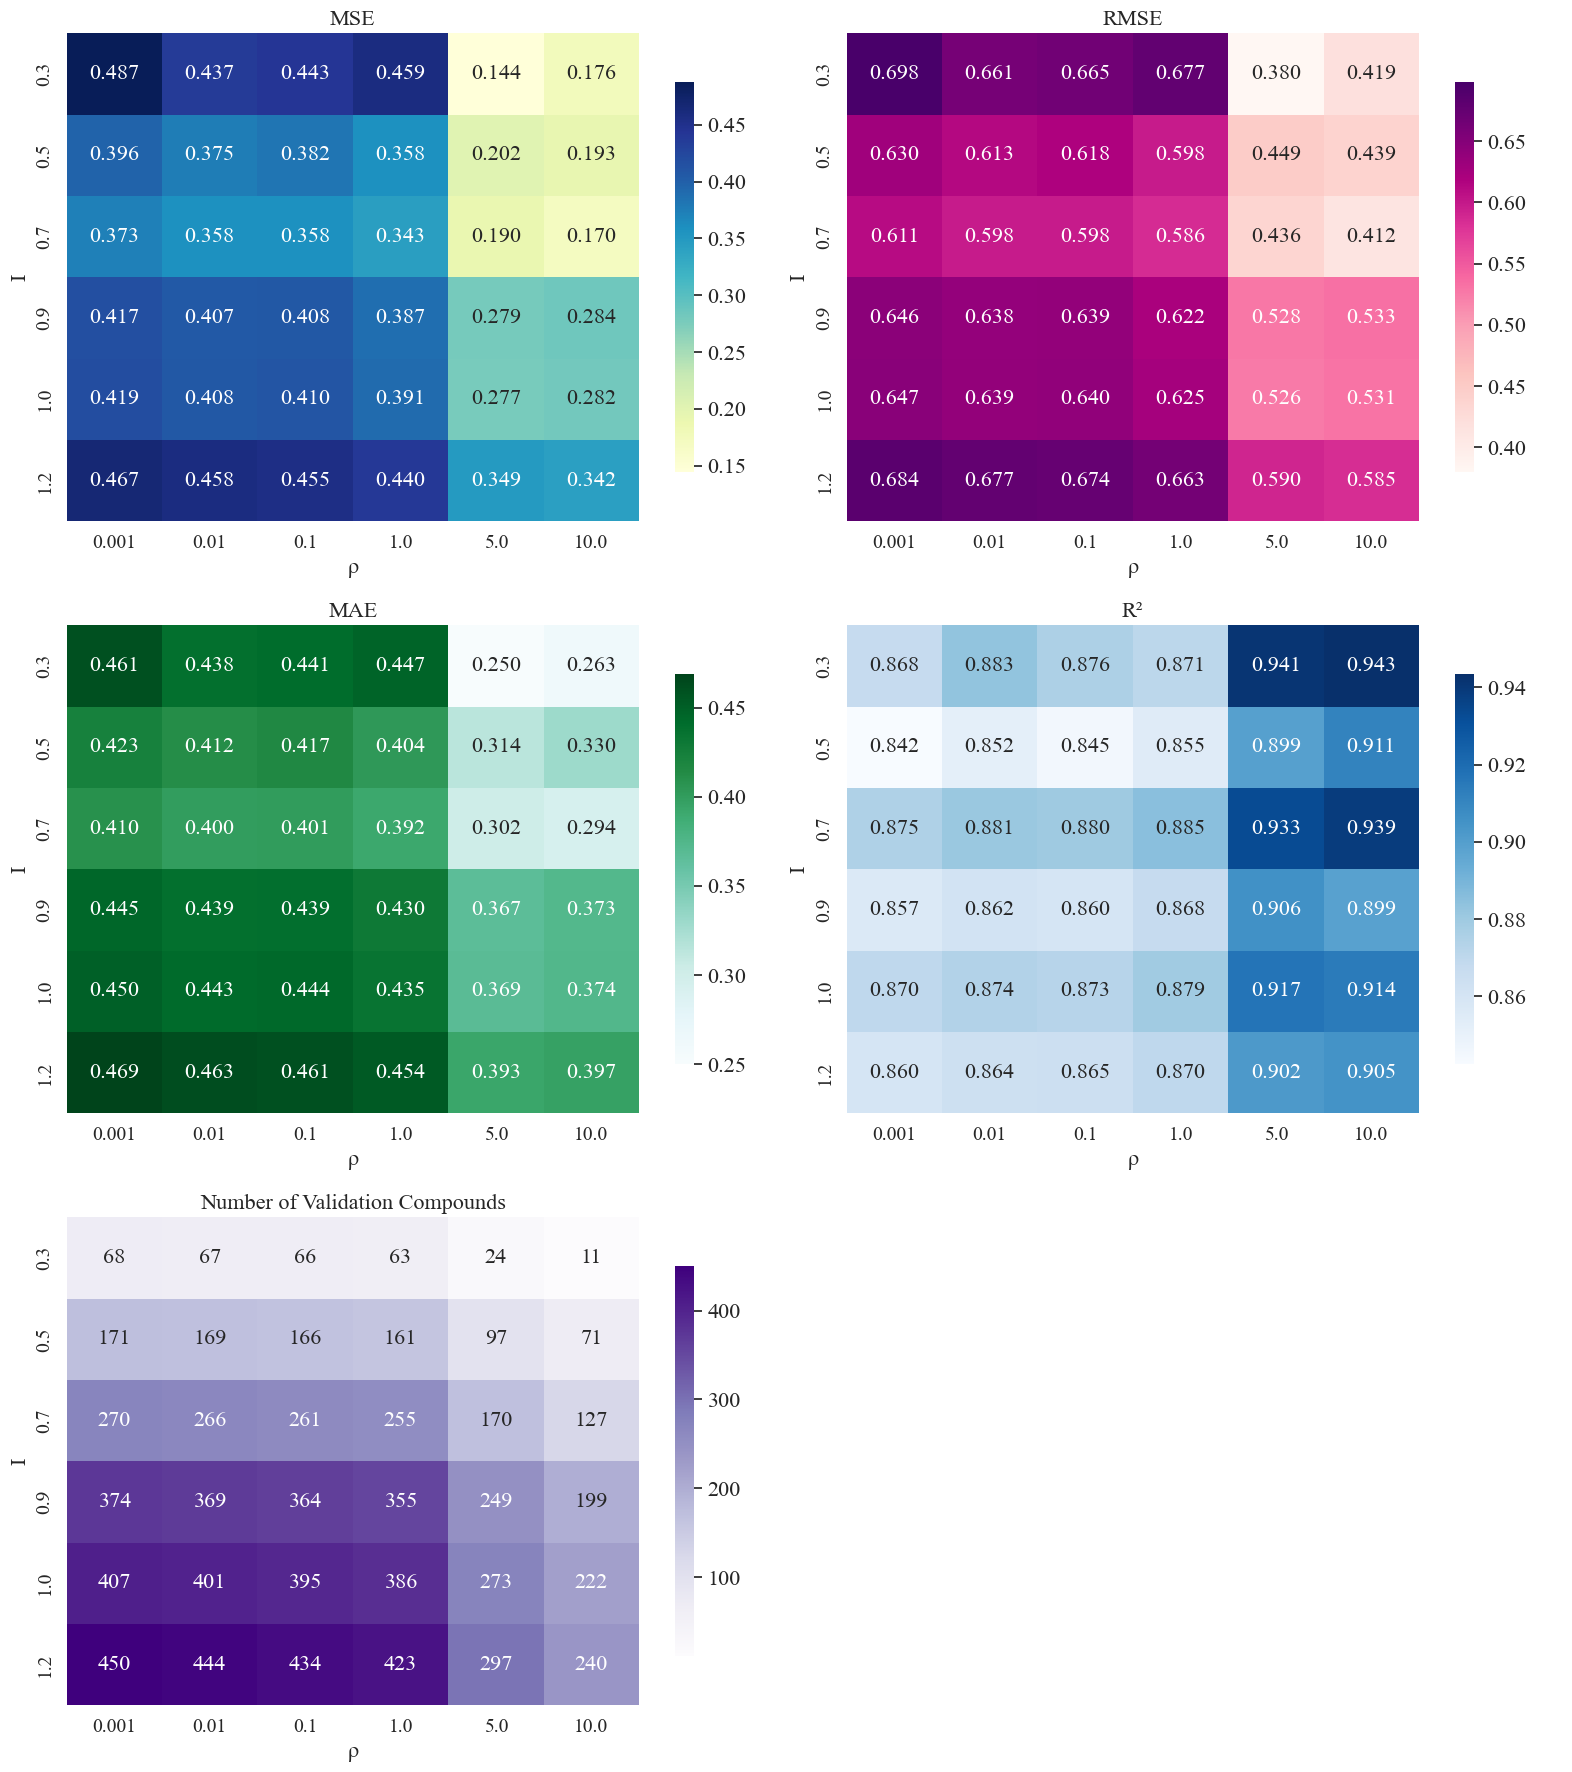

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 all_list_df 已经创建并包含所有结果
print(all_list_df.head())

# 将数据框转换为适合绘制热图的格式
pivot_mse = all_list_df.pivot('I', 'P', 'MSE')
pivot_rmse = all_list_df.pivot('I', 'P', 'RMSE')
pivot_mae = all_list_df.pivot('I', 'P', 'MAE')
pivot_r2 = all_list_df.pivot('I', 'P', 'R²')
pivot_num_remained = all_list_df.pivot('I', 'P', 'Num Remained')

# 设置绘图风格
sns.set(style='whitegrid')

# 设置字体
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

# 创建子图
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 调整横纵轴刻度标签的字号
tick_label_fontsize = 14  # 设置横纵轴刻度标签字号为 14
cbar_fontsize = 16  # 设置颜色条数字的字号为 16

# 绘制 MSE 热图
sns_mse = sns.heatmap(pivot_mse, ax=axes[0, 0], annot=True, fmt=".3f", cmap='YlGnBu', cbar_kws={'shrink': 0.8})
axes[0, 0].set_title('MSE', fontsize=16)
axes[0, 0].tick_params(axis='both', labelsize=tick_label_fontsize)
sns_mse.collections[0].colorbar.ax.tick_params(labelsize=cbar_fontsize)  # 调整颜色条字体大小

# 绘制 RMSE 热图
sns_rmse = sns.heatmap(pivot_rmse, ax=axes[0, 1], annot=True, fmt=".3f", cmap='RdPu', cbar_kws={'shrink': 0.8})
axes[0, 1].set_title('RMSE', fontsize=16)
axes[0, 1].tick_params(axis='both', labelsize=tick_label_fontsize)
sns_rmse.collections[0].colorbar.ax.tick_params(labelsize=cbar_fontsize)  # 调整颜色条字体大小

# 绘制 MAE 热图
sns_mae = sns.heatmap(pivot_mae, ax=axes[1, 0], annot=True, fmt=".3f", cmap='BuGn', cbar_kws={'shrink': 0.8})
axes[1, 0].set_title('MAE', fontsize=16)
axes[1, 0].tick_params(axis='both', labelsize=tick_label_fontsize)
sns_mae.collections[0].colorbar.ax.tick_params(labelsize=cbar_fontsize)  # 调整颜色条字体大小

# 绘制 R² 热图
sns_r2 = sns.heatmap(pivot_r2, ax=axes[1, 1], annot=True, fmt=".3f", cmap='Blues', cbar_kws={'shrink': 0.8})
axes[1, 1].set_title('R²', fontsize=16)
axes[1, 1].tick_params(axis='both', labelsize=tick_label_fontsize)
sns_r2.collections[0].colorbar.ax.tick_params(labelsize=cbar_fontsize)  # 调整颜色条字体大小

# 绘制 Number of Validation Compounds 热图
sns_num_remained = sns.heatmap(pivot_num_remained, ax=axes[2, 0], annot=True, fmt=".0f", cmap='Purples', cbar_kws={'shrink': 0.8})
axes[2, 0].set_title('Number of Validation Compounds', fontsize=16)
axes[2, 0].tick_params(axis='both', labelsize=tick_label_fontsize)
sns_num_remained.collections[0].colorbar.ax.tick_params(labelsize=cbar_fontsize)  # 调整颜色条字体大小

# 设置通用标签
for ax in axes.flat:
    ax.set_xlabel('ρ', fontsize=16)
    ax.set_ylabel('I', fontsize=16)

# 删除空白的子图框架
axes[2, 1].axis('off')

# 调整布局并保存图片
plt.tight_layout()
plt.savefig(r'C:\Users\Zhu_lele\Desktop\论文-全球海洋生态系统中化学品污染与生物多样性损失关联\图表\python文件\应用域表征\应用域表征图.png', dpi=300, bbox_inches='tight')

# 显示图表
plt.show()
